# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import json
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from plotting_functions import plot_roc_curves, plot_classification_reports_averages, plot_confusion_matrices
from utils import build_resampled_datasets, best_f1_score_for_each_sampling_method
# from google.colab import drive
# drive.mount('/content/drive')

## 1.1 Φόρτωση των δεδομένων
Φορτώνουμε τα δεδομένα από το αρχείο `movies.xlsx` σε ένα pandas dataframe.

In [2]:
pd.set_option('display.max_columns', None)
# Truncate
pd.set_option('display.max_rows', False) # Change False to None to not truncate

In [3]:
df = pd.read_excel('movies.xlsx')
last_idx = len(df) - 1

df_un_orig = pd.read_excel('movies_test_anon.xlsx')
# df_unkwn = pd.read_excel('movies_test_anon_sample.xlsx')

# Concat two dataframes
df = pd.concat([df, df_un_orig.drop(['ID'], axis=1)])

Μετονομάζουμε τις στήλες σε πιο χρήσιμα ονόματα αφαιρώντας τα επιπλέον κενά. 

In [4]:
# remove double spaces, leading and trailing spaces and replace them with _ and convert to lowercase
new_names_dict = dict(zip(df.columns, list(x.strip().replace(" ", "_").replace("__", "_").lower() for x in df.columns)))

# replace df_unkwn_unkwn_unkwn_unkwn columns
df = df.rename(columns=new_names_dict)

## 1.2 Γενική εικόνα των δεδομένων
Βλέπουμε το περιεχόμενο του dataframe εμφανίζοντας τις πρώτες 5 γραμμές.

In [5]:
# split
df_un = df.iloc[last_idx+1:]
df = df.iloc[:last_idx+1]

Τα βασικά χαρακτηριστικά του dataframe όπως τον αριθμό των γραμμών και τον τύπο των δεδομένων της κάθε στήλης.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   film                                    1402 non-null   object 
 1   year                                    1402 non-null   int64  
 2   script_type                             1402 non-null   object 
 3   rotten_tomatoes_critics                 1401 non-null   object 
 4   metacritic_critics                      1402 non-null   object 
 5   average_critics                         1402 non-null   object 
 6   rotten_tomatoes_audience                1401 non-null   float64
 7   metacritic_audience                     1402 non-null   object 
 8   rotten_tomatoes_vs_metacritic_deviance  1402 non-null   object 
 9   average_audience                        1402 non-null   object 
 10  audience_vs_critics_deviance            1402 non-null   object 
 

Βασικά στατιστικά των στηλών που περιλαμβάνων αριθμητικούς τύπους δεδομένων όπως τη μέση τιμή και τη κανονική κατανομή.  

In [7]:
df.describe().T

count         mean        std     min     25%  \
year                      1402.0  2012.140514   3.190291  2007.0  2009.0   
rotten_tomatoes_audience  1401.0    62.122769  17.435737    17.0    49.0   
imdb_rating                  0.0          NaN        NaN     NaN     NaN   
imdb_vs_rt_disparity         0.0          NaN        NaN     NaN     NaN   

                             50%     75%     max  
year                      2012.0  2015.0  2017.0  
rotten_tomatoes_audience    62.0    76.0    98.0  
imdb_rating                  NaN     NaN     NaN  
imdb_vs_rt_disparity         NaN     NaN     NaN

Κάποιες επιπλέον ιδιότητες του dataframe συμπεριλαμβανομένου και του τύπου δεδομένων `object`

In [8]:
df.describe(include='object').T

count  unique                    top  \
film                                      1402    1396            Big Miracle   
script_type                               1402      17    original screenplay   
rotten_tomatoes_critics                   1401     102                     93   
metacritic_critics                        1402      90                     51   
average_critics                           1402     196                     64   
metacritic_audience                       1402      78                     66   
rotten_tomatoes_vs_metacritic_deviance    1402      82                     -1   
average_audience                          1402     116                     58   
audience_vs_critics_deviance              1402      78                     -5   
...                                        ...     ...                    ...   
worldwide_gross_($million)              1402.0  1141.0                   78.0   
of_gross_earned_abroad                    1402    1230                  0.00%   
budget_($million)                         1402     192                     20   
budget_recovered                          1402    1365                      -   
budget_recovered_opening_weekend          1402    1266                      -   
distributor                                  0       0                    NaN   
release_date_(us)                         1402     671            Apr 7, 2017   
oscar_winners                               56       2           Oscar winner   
oscar_detail                                56      38  Best Animated Feature   

                                       freq  
film                                      2  
script_type                             546  
rotten_tomatoes_critics                  29  
metacritic_critics                       39  
average_critics                          25  
metacritic_audience                      50  
rotten_tomatoes_vs_metacritic_deviance   58  
average_audience                         45  
audience_vs_critics_deviance             54  
...                                     ...  
worldwide_gross_($million)              7.0  
of_gross_earned_abroad                   58  
budget_($million)                        84  
budget_recovered                          6  
budget_recovered_opening_weekend          6  
distributor                             NaN  
release_date_(us)                         7  
oscar_winners                            36  
oscar_detail                              7  

[27 rows x 4 columns]

# 2. Καθάρισμα δεδομένων
Ελέγχουμε και αντιμετωπίζουμε **missing values**, **outliers** και **διπλότυπα**.


## 2.1 Έλεγχος για διπλότυπα

Ελέγχουμε για διπλότυπα με το όνομα της ταινίας.

In [9]:
df[df.duplicated(subset=['film'], keep=False)]

film  year            script_type rotten_tomatoes_critics  \
681       That's My Boy  2012    original screenplay                      20   
682       That's My Boy  2012    original screenplay                      20   
703         Big Miracle  2012             adaptation                      74   
704         Big Miracle  2012             adaptation                      74   
709        Premium Rush  2012    original screenplay                      76   
710        Premium Rush  2012    original screenplay                      76   
713          The Master  2012    original screenplay                      85   
714          The Master  2012    original screenplay                      85   
1001  The Good Dinosaur  2015    original screenplay                      77   
1062      The Big Short  2015             adaptation                      87   
1135  The Good Dinosaur  2016    original screenplay                      77   
1168      The Big Short  2016  based on a true story                      88   

     metacritic_critics average_critics  rotten_tomatoes_audience  \
681                  31              26                      53.0   
682                  31              26                      53.0   
703                  61              68                      64.0   
704                  61              68                      64.0   
709                  66              71                      60.0   
710                  66              71                      60.0   
713                  86              86                      59.0   
714                  86              86                      59.0   
1001                 66              72                      66.0   
1062                 81              84                      89.0   
1135                 66            71.5                      66.0   
1168                 81            84.5                      88.0   

     metacritic_audience rotten_tomatoes_vs_metacritic_deviance  \
681                   54                                     -1   
682                   54                                     -1   
703                   59                                      5   
704                   59                                      5   
709                   68                                     -8   
710                   68                                     -8   
713                   69                                    -10   
714                   69                                    -10   
1001                  70                                     -4   
1062                  89                                      0   
1135                  70                                     -4   
1168                  82                                      6   

     average_audience audience_vs_critics_deviance primary_genre  \
681                54                          -28           NaN   
682                54                          -28           NaN   
703                62                            6           NaN   
704                62                            6           NaN   
709                64                            7           NaN   
710                64                            7           NaN   
713                64                           22           NaN   
714                64                           22           NaN   
1001               68                            4           NaN   
1062               89                           -5           NaN   
1135               68                            4           NaN   
1168               85                           -1           NaN   

                        genre opening_weekend opening_weekend_($million)  \
681                    comedy        13453714                      13.45   
682                    comedy        13453714                       13.0   
703                   romance         7760205                       7.76   
704                

Διαγραφή διπλότυπων

## 2.2 Απών τιμές
Ελέγχουμε για τυχών απών τιμές όπως `NaN` και `-`.

In [10]:
#Concat
df = pd.concat([df, df_un])

Μετατροπή άκυρων τιμών σε NaN

In [11]:
# replace white characters with NaN
df = df.replace(r'^-$', np.nan, regex=True)
#Count NaN values per column
df.isna().sum()

film                                         0
year                                         0
script_type                                193
rotten_tomatoes_critics                      6
metacritic_critics                          18
average_critics                             12
rotten_tomatoes_audience                     1
metacritic_audience                         19
rotten_tomatoes_vs_metacritic_deviance      19
average_audience                            11
audience_vs_critics_deviance                16
primary_genre                             1689
                                          ... 
worldwide_gross                             23
worldwide_gross_($million)                  22
of_gross_earned_abroad                     132
budget_($million)                           74
budget_recovered                            92
budget_recovered_opening_weekend            88
distributor                               1562
imdb_rating                               1405
imdb_vs_rt_di

Μετατροπή σε αριθμητικά

In [12]:
# Remove invalid characters from numerical strings
df = df.apply(lambda x: x.replace(',','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('%','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
df = df.apply(lambda x: x.replace('#VALUE!','', regex=True) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)
# Convert strings to numbers
df = df.apply(lambda x: pd.to_numeric(x) if x.name not in ['film', 'script_type', 'primary_genre', 'genre', 'release_date_(us)', 'distributor', 'oscar_winners', 'oscar_detail'] else x, axis=0)

Υπολογισμός NaN τιμών από άλλες τιμές όπου είναι εφικτό

In [13]:
df['metacritic_critics'] = df.apply(lambda row: row['average_critics'] * 2 - row['rotten_tomatoes_critics'] if pd.isnull(row['metacritic_critics']) and pd.notnull(row['average_critics']) else row['metacritic_critics'], axis=1)
df['average_critics'] = df.apply(lambda row: (row['rotten_tomatoes_critics'] + row['metacritic_critics']) / 2 if pd.isnull(row['average_critics']) else row['average_critics'], axis=1)
df['metacritic_audience'] = df.apply(lambda row: row['average_audience'] * 2 - row['rotten_tomatoes_audience'] if pd.isnull(row['metacritic_audience']) and pd.notnull(row['average_audience']) else row['metacritic_audience'], axis=1)
df['rotten_tomatoes_vs_metacritic_deviance'] = df.apply(lambda row: row['rotten_tomatoes_audience'] - row['metacritic_audience'] if pd.isnull(row['rotten_tomatoes_vs_metacritic_deviance']) and pd.notnull(row['rotten_tomatoes_audience']) and pd.notnull(row['metacritic_audience']) else row['rotten_tomatoes_vs_metacritic_deviance'], axis=1)
df['foreign_gross'] = df.apply(lambda row: row['worldwide_gross'] - row['domestic_gross'] if pd.isnull(row['foreign_gross']) and pd.notnull(['worldwide_gross']) and pd.notnull(['domestic_gross']) else row['foreign_gross'], axis=1)
df['foreign_gross_($million)'] = df.apply(lambda row: row['foreign_gross'] / 1000 if pd.isnull(row['foreign_gross_($million)']) and pd.notnull(row['foreign_gross']) else row['foreign_gross_($million)'], axis=1)
df['of_gross_earned_abroad'] = df.apply(lambda row: row['foreign_gross'] / row['worldwide_gross'] if pd.isnull(row['of_gross_earned_abroad']) and pd.notnull(row['foreign_gross']) and pd.notnull(row['worldwide_gross']) else row['foreign_gross_($million)'], axis=1)
df['budget_recovered'] = df.apply(lambda row: row['worldwide_gross_($million)'] / row['budget_($million)'] * 100 if pd.isnull(row['budget_recovered']) and pd.notnull(row['worldwide_gross_($million)']) and pd.notnull(row['budget_($million)']) else row['budget_recovered'], axis=1)
df['budget_recovered_opening_weekend'] = df.apply(lambda row: row['opening_weekend'] / row['worldwide_gross'] * 100 if pd.isnull(row['budget_recovered_opening_weekend']) and pd.notnull(row['opening_weekend']) and pd.notnull(row['worldwide_gross']) else row['budget_recovered_opening_weekend'], axis=1)

Αντικατάσταση κατηγορηματικών τιμών

In [14]:
df['script_type'] = df['script_type'].fillna(df['script_type'].describe()['top'])
df['primary_genre'] = df['primary_genre'].fillna(df['primary_genre'].describe()['top'])
df['genre'] = df['genre'].fillna(df['genre'].describe()['top'])

Αντικατάσταση εναπομείναντων NaN τιμών με το μέσο όρο της στήλης όπου δεν είναι δυνατόν να υπολογιστεί.

In [15]:
df.loc[:, 'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'] = df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].fillna(df.loc[:,  'rotten_tomatoes_critics' : 'audience_vs_critics_deviance'].mean())
df.loc[:, 'opening_weekend' : 'budget_recovered_opening_weekend'] = df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].fillna(df.loc[:,  'opening_weekend' : 'budget_recovered_opening_weekend'].mean())

## 2.3 Έλεγχος για outliers
Ελέγχουμε και διορθώνουμε τυχών outliers με πρώτο βήμα να μετατρέψουμε τις συμβολοσειρές σε κανονικές αριθμητικές μεταβλητές float ή integer. Επίσης μετατρέπουμε την στήλη `oscar_winners` σε 0 ή 1.

In [16]:
# Detect critic values outside normal range
df[(df['rotten_tomatoes_audience'] < 0) | (df['rotten_tomatoes_audience'] > 100) | (df['rotten_tomatoes_critics'] < 0) | (df['rotten_tomatoes_critics'] > 100)
   | (df['metacritic_critics'] < 0 ) | (df['metacritic_critics'] > 100) |  (df['metacritic_audience'] < 0 ) | (df['metacritic_audience']) > 100].sum()

film                                        0
year                                        0
script_type                                 0
rotten_tomatoes_critics                   0.0
metacritic_critics                        0.0
average_critics                           0.0
rotten_tomatoes_audience                  0.0
metacritic_audience                       0.0
rotten_tomatoes_vs_metacritic_deviance    0.0
average_audience                          0.0
audience_vs_critics_deviance              0.0
primary_genre                               0
                                         ... 
worldwide_gross                           0.0
worldwide_gross_($million)                0.0
of_gross_earned_abroad                    0.0
budget_($million)                         0.0
budget_recovered                          0.0
budget_recovered_opening_weekend          0.0
distributor                                 0
imdb_rating                               0.0
imdb_vs_rt_disparity              

Τελευταία διόρθωση συγκεκριμένων εσφαλμένων τιμών

In [17]:
df['budget_($million)'] = df.apply(lambda row: row['budget_($million)'] / 1000 if row['budget_($million)'] > 999 else row['budget_($million)'], axis=1)

# Convert 'of_gross_earned_abroad to 0-1 range
df['of_gross_earned_abroad'] = df['of_gross_earned_abroad'].apply(lambda s: s / 100)

Μία στατιστική εικόνα του dataframe με διορθωμένες αριθμητικές τιμές.

In [18]:
# df = df.reset_index()
# df = df.drop(['index'],axis=1)
df.describe().apply(lambda s: s.apply('{0:.2f}'.format)).T

count          mean           std  \
year                                    1967.00       2014.31          4.42   
rotten_tomatoes_critics                 1967.00         55.79         27.22   
metacritic_critics                      1967.00         54.53         17.19   
average_critics                         1967.00         55.37         21.80   
rotten_tomatoes_audience                1967.00         65.10         18.53   
metacritic_audience                     1967.00         62.32         13.75   
rotten_tomatoes_vs_metacritic_deviance  1967.00          2.83         14.96   
average_audience                        1967.00         63.90         14.58   
audience_vs_critics_deviance            1967.00         -8.59         14.89   
...                                         ...           ...           ...   
foreign_gross                           1967.00   99480521.47  169958370.49   
worldwide_gross                         1967.00  169718630.00  253746108.20   
worldwide_gross_($million)              1967.00        285.64        925.58   
of_gross_earned_abroad                  1967.00          7.72        138.28   
budget_($million)                       1967.00         57.07         56.01   
budget_recovered                        1967.00       1058.73      29124.86   
budget_recovered_opening_weekend        1967.00        120.89       2956.07   
imdb_rating                              562.00          6.37          0.91   
imdb_vs_rt_disparity                     405.00         12.56         14.84   

                                                  min          25%  \
year                                          2007.00      2010.00   
rotten_tomatoes_critics                          0.00        32.00   
metacritic_critics                               0.00        42.00   
average_critics                                  0.00        37.00   
rotten_tomatoes_audience                         8.00        51.00   
metacritic_audience                              2.00        54.00   
rotten_tomatoes_vs_metacritic_deviance         -60.00        -7.00   
average_audience                                 5.00        54.00   
audience_vs_critics_deviance                   -68.00       -19.00   
...                                               ...          ...   
foreign_gross                           -145676542.00   7486213.50   
worldwide_gross                             398495.00  30771012.00   
worldwide_gross_($million)                       0.00        33.08   
of_gross_earned_abroad                          -0.04         0.05   
budget_($million)                                0.10        18.10   
budget_recovered                                 0.04        20.45   
budget_recovered_opening_weekend                 0.00         1.25   
imdb_rating                                      2.50         5.80   
imdb_vs_rt_disparity                           -44.00         5.00   

                                                50%           75%  \
year                                        2015.00       2018.00   
rotten_tomatoes_critics                       57.00         81.00   
metacritic_critics                            54.00         66.00   
average_critics                               56.00         74.00   
rotten_tomatoes_audience                      66.00         80.00   
metacritic_audience                           64.00         72.00   
rotten_tomatoes_vs_metacritic_deviance         2.00         11.00   
average_audience                              65.00         75.00   
audience_vs_critics_deviance                  -8.00          2.00   
...                                             ...           ...   
foreign_gross                           36070000.00  105698034.50   
worldwide_gross                         78324220.00  193665000.00   
worldwide_gross_($million)                    88.00        236.00   
of_gross_earned_abroad                         0.33          1.11   
budget_($million)        

# 3. Εξερεύνηση χαρακτηριστικών
Εξερευνούμε τα χαρακτηριστικά των δεδομένων εκτελώντας αλγόριθμούς υπολογισμού συσχετίσεων και PCA

## 3.1 Προεπεξεργασία των δεδομένων

Μετατροπή των στηλών `script_typr` και `genre` σε 1 hot encoding

In [19]:
# Make a copy of dataframe
df_cl = df

In [20]:
# Convert strings to lowercase
df_cl['script_type'] = df_cl['script_type'].str.lower()

# Extract all unique script type names
script_types = df_cl['script_type'].unique()

# Split strings and remove trailing spaces
types = []
for string in script_types:
    types.append(re.split(' / |, ',string))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
unique_script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(unique_script_types):
    # df.insert(i+1, 'st_'+item, 0)
    # df.insert(-1, 'st_'+item, 0)
    df_cl.insert(i, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for script in unique_script_types:
        if script in df_cl.at[i, 'script_type']:
            df_cl.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df_cl = df_cl.drop(['script_type'], axis=1)

In [21]:
# Convert genres to lower to avoid possible dublication
df_cl['genre'] = df_cl['genre'].str.lower()
genres = df_cl['genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for string in genres:
    unique_genres.append(re.split(', |. ',string))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')
genre_types.remove('blac')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    # df.insert(i+9, 'gen_'+item, 0)
    df_cl.insert(i, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df_cl.index:
    for genr in genre_types:
        if genr in df_cl.at[i, 'genre']:
            df_cl.at[i, 'gen_'+genr] = 1

# Drop original genre column
df_cl = df_cl.drop(['genre'], axis=1)

# Drop unecessary primary genre
df_cl = df_cl.drop(['primary_genre'], axis=1)

In [22]:
# Convert Oscar Winners to 1 hot encoding
df_cl['oscar_winners'] = df_cl["oscar_winners"].notnull().astype("int")

Μία γενική εικόνα του dataframe μετά τους μετασχηματισμούς

In [23]:
df_cl.head().T

0            1             2  \
gen_western                                 0            0             0   
gen_romance                                 0            0             0   
gen_biography                               0            0             0   
gen_war                                     0            0             0   
gen_history                                 0            0             0   
gen_suspense                                0            0             0   
gen_fanstasy                                0            0             0   
gen_fantasy                                 0            0             0   
gen_horror                                  0            0             0   
...                                       ...          ...           ...   
budget_($million)                        65.0         50.0          32.0   
budget_recovered                       701.64       139.56        234.67   
budget_recovered_opening_weekend       109.05        28.07         49.85   
distributor                               NaN          NaN           NaN   
imdb_rating                               NaN          NaN           NaN   
imdb_vs_rt_disparity                      NaN          NaN           NaN   
release_date_(us)                 Mar 9, 2007  Sep 7, 2007  Oct 19, 2007   
oscar_winners                               0            0             0   
oscar_detail                              NaN          NaN           NaN   

                                             3             4  
gen_western                                  0             0  
gen_romance                                  0             0  
gen_biography                                0             0  
gen_war                                      0             0  
gen_history                                  0             0  
gen_suspense                                 0             0  
gen_fanstasy                                 0             0  
gen_fantasy                                  0             0  
gen_horror                                   0             0  
...                                        ...           ...  
budget_($million)                         45.0          40.0  
budget_recovered                         65.26        322.21  
budget_recovered_opening_weekend           8.5         25.15  
distributor                                NaN           NaN  
imdb_rating                                NaN           NaN  
imdb_vs_rt_disparity                       NaN           NaN  
release_date_(us)                 Oct 12, 2007  Dec 25, 2007  
oscar_winners                                0             0  
oscar_detail                               NaN           NaN  

[62 rows x 5 columns]

## 3.2 Ανάλυση συσχετίσεων

### 3.2.1 Συσχέτιση χαρακτηριστικών με τη στήλη `oscar_winners`
Υπολογίζουμε την συσχέτιση με τη στήλη `oscar_winners` για να διαπιστώσουμε ποιο χαρακτηριστικό συμβάλει περισσότερο στο αν έχει πάρει oscar μία ταινία. Χωρίς έκπληξη διαπιστώνουμε ότι οι κριτικές έχουν τη μεγαλύτερη βαρύτητα όμως γενικά οί συσχετίσεις είναι μικρές.

In [24]:
# # split
df_un_cl = df_cl.iloc[last_idx+1:]
df_cl = df_cl.iloc[:last_idx+1]
df_cl = df_cl.reset_index().drop(['index'], axis=1)

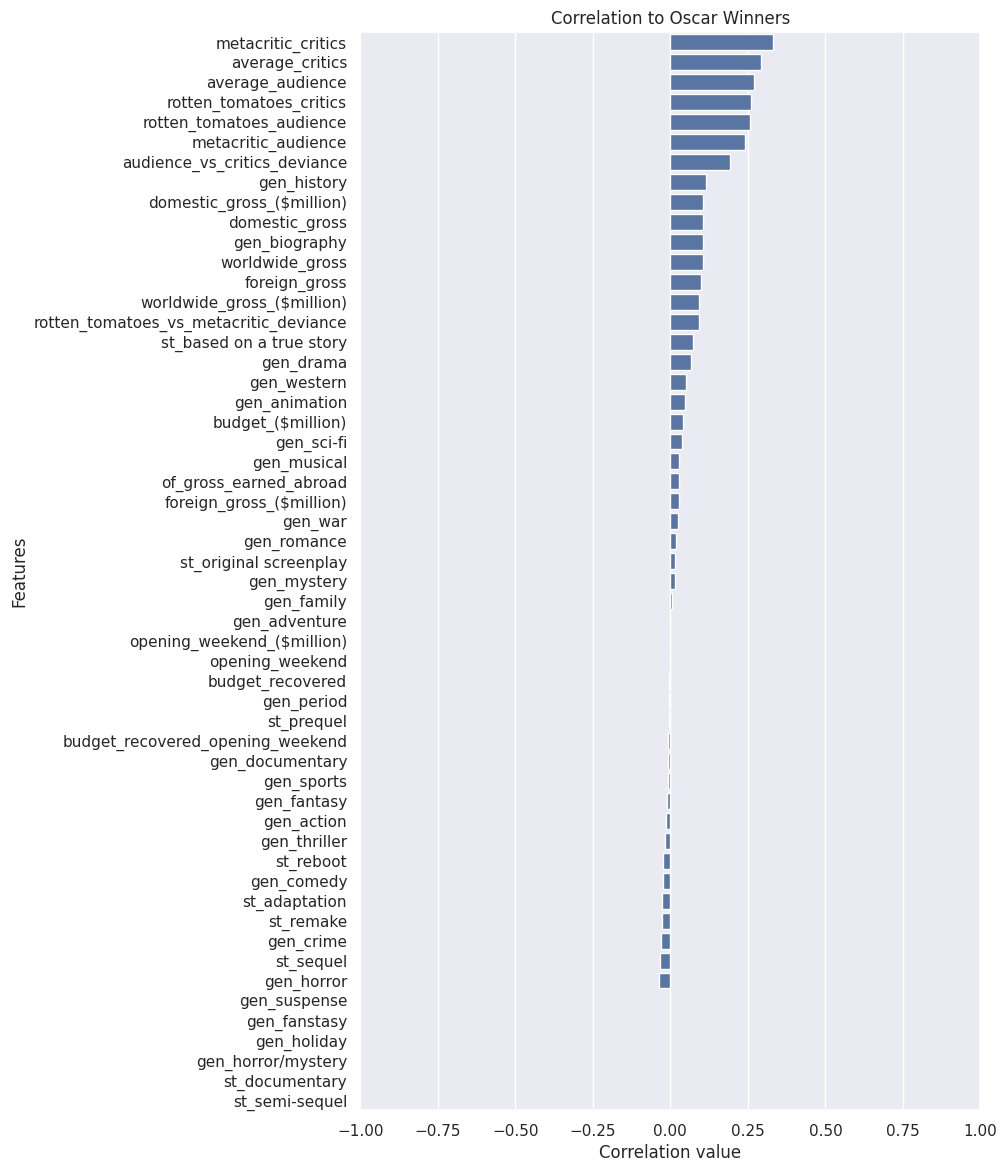

In [25]:
# remove non relevant columns
# df_cl_corr = df_cl.drop(['Film', 'Year','Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Release Date (US)','Oscar Detail'], axis=1)

# Remove non relevant columns and average critics columns
df_cl_corr = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)

# Calculate correlation values and grab last row
corr = df_cl_corr.corr()
last_row = pd.DataFrame(corr.iloc[-1, :-1]).sort_values(by='oscar_winners', ascending=False)

sns.set_theme()
plt.figure(figsize=(8, 14))
plt.title('Correlation to Oscar Winners')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.xlim(-1, 1)
sns.barplot(data=last_row, x='oscar_winners', y=last_row.index)
plt.show()

### 3.2.2 Υπολογισμός Variance Inflation Factor
Υπολογίζουμε το Variance Inflation Factor των χαρακτηριστικών για να διαπιστώσουμε αν υπάρχει φαινόμενο multicollinearity. Σύμφωνα με το αποτέλεσμα υπάρχει τεράστιο φαινόμενο multicollinearity καθώς κάποιες τιμές είναι πολύ μεγάλες.


In [26]:
# TODO: Strategy for dealing with high multicollinearity ?

# Drop labels from set
X = df_cl_corr.drop(['oscar_winners'], axis=1)
  
# VIF dataframe
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
vif_data["VIF"] = vif_data["VIF"].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# pd.options.display.float_format = '{:.2f}'.format
vif_data

/home/mike/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/mike/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature         VIF
46    foreign_gross_($million)         inf
50      of_gross_earned_abroad         inf
45   domestic_gross_($million)  3195436.80
44              domestic_gross  3194174.49
42             opening_weekend   523193.41
43  opening_weekend_($million)   523183.52
38         metacritic_audience    13537.84
34     rotten_tomatoes_critics    13354.20
37    rotten_tomatoes_audience    12599.41
..                         ...         ...
19                  gen_period        1.03
33                  st_prequel        1.02
15             gen_documentary        1.02
5                 gen_suspense         NaN
6                 gen_fanstasy         NaN
16                 gen_holiday         NaN
24          gen_horror/mystery         NaN
29              st_documentary         NaN
31              st_semi-sequel         NaN

[54 rows x 2 columns]

### 3.2.3 Πίνακας συσχέτισης
Υπολογίζουμε τον πίνακα συσχέτισης μεταξύ όλων των χαρακτηριστικών.

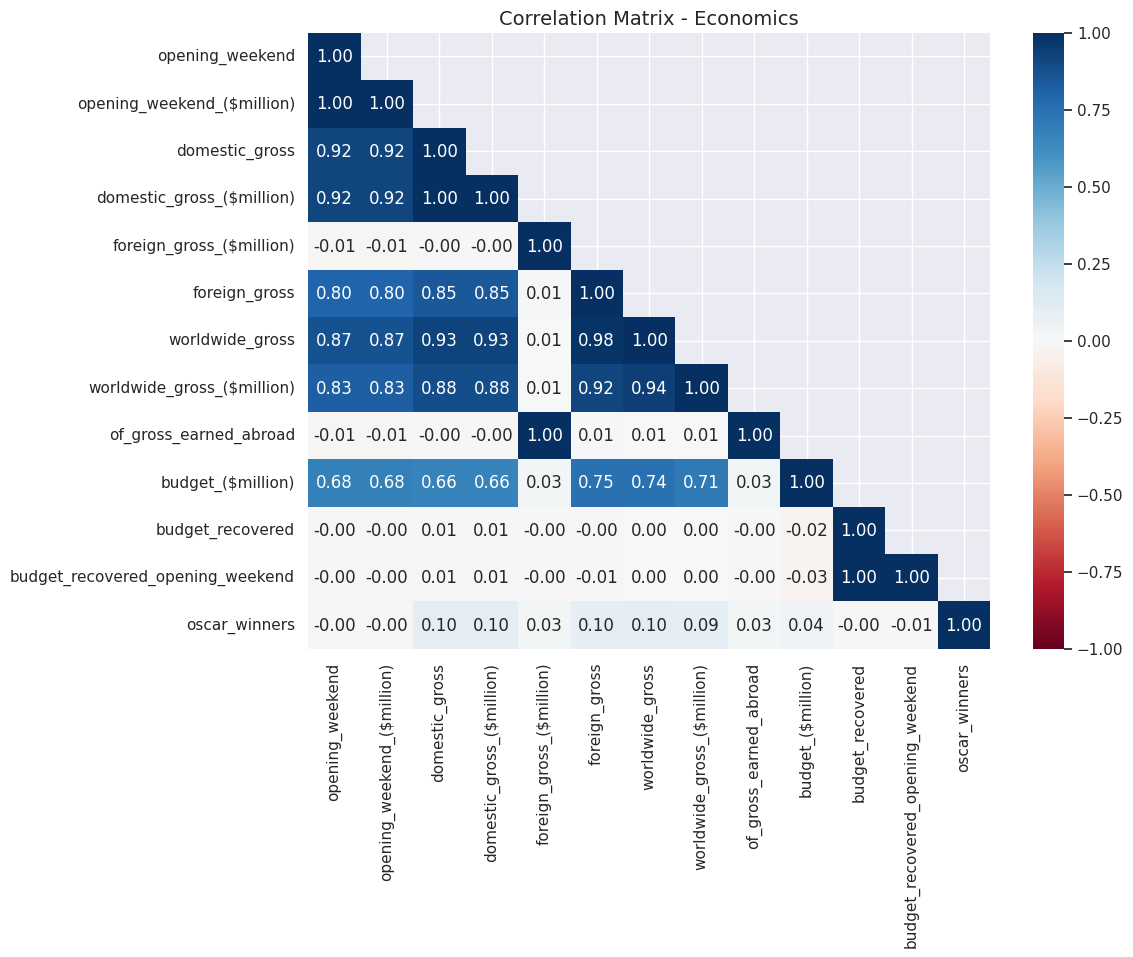

In [27]:
# Economics
corr_mat = df_cl_corr[['opening_weekend',
       'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'foreign_gross', 'worldwide_gross', 'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(11, 8))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Economics', fontsize=14)
plt.show()

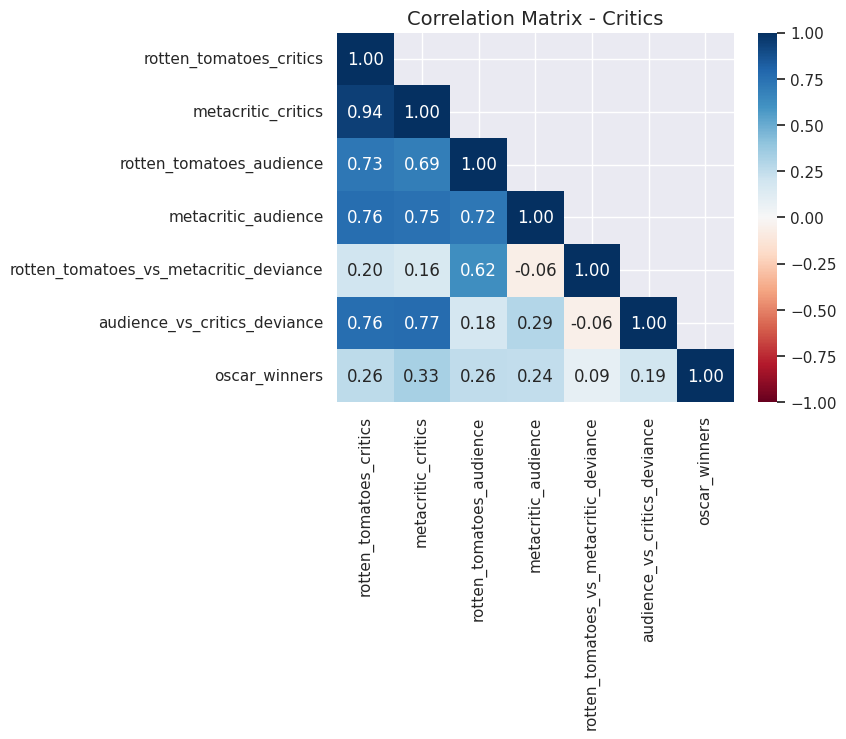

In [28]:
# Economics
corr_mat = df_cl_corr[['rotten_tomatoes_critics', 'metacritic_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'rotten_tomatoes_vs_metacritic_deviance',
       'audience_vs_critics_deviance','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
# plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Critics', fontsize=14)
plt.show()

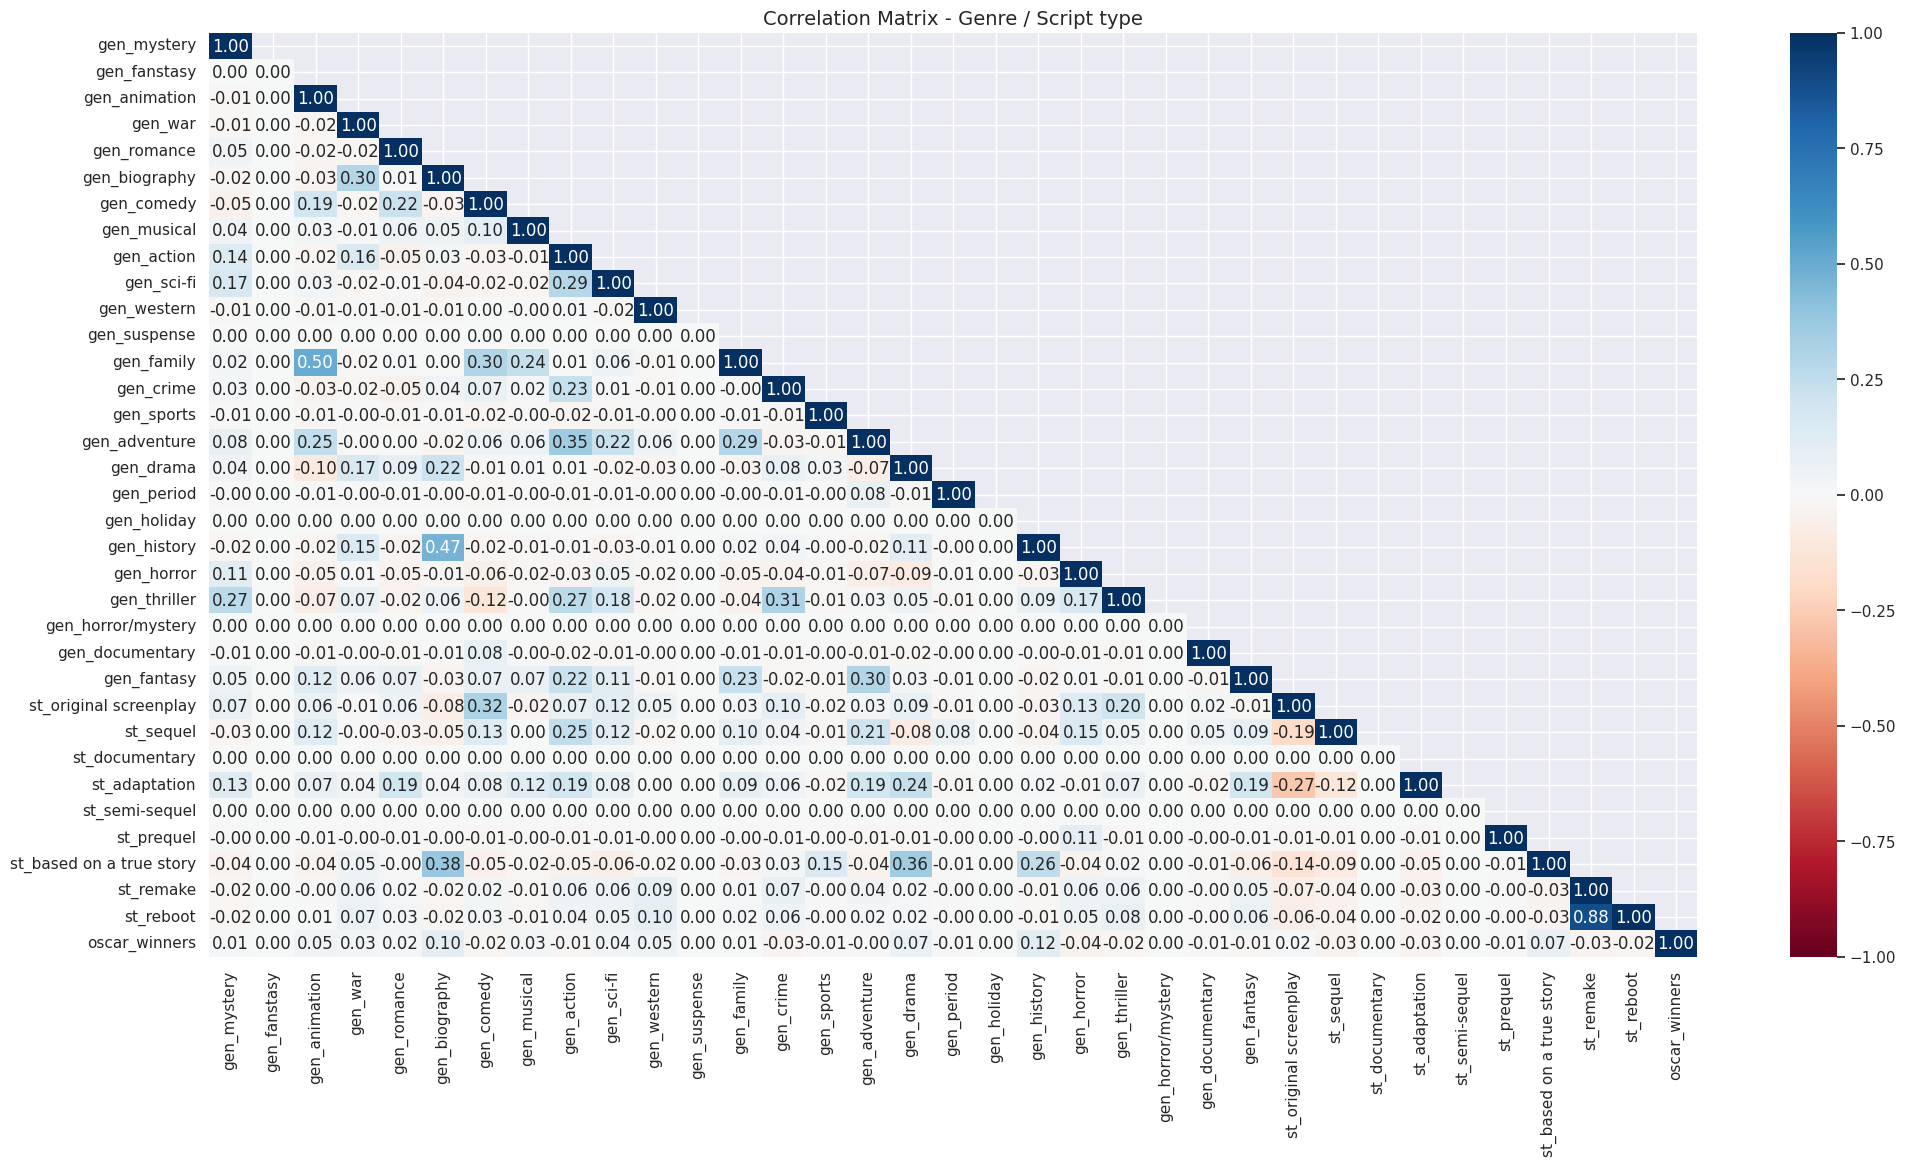

In [29]:
# Economics
corr_mat = df_cl_corr[['gen_mystery', 'gen_fanstasy', 'gen_animation', 'gen_war',
       'gen_romance', 'gen_biography', 'gen_comedy', 'gen_musical',
       'gen_action', 'gen_sci-fi', 'gen_western', 'gen_suspense', 'gen_family',
       'gen_crime', 'gen_sports', 'gen_adventure', 'gen_drama', 'gen_period',
       'gen_holiday', 'gen_history', 'gen_horror', 'gen_thriller',
       'gen_horror/mystery', 'gen_documentary', 'gen_fantasy',
       'st_original screenplay', 'st_sequel', 'st_documentary',
       'st_adaptation', 'st_semi-sequel', 'st_prequel',
       'st_based on a true story', 'st_remake', 'st_reboot','oscar_winners']].corr()
corr_mat = corr_mat.fillna(0)

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask, k=1)] = True

sns.set_theme()
plt.figure(figsize=(24, 12))
sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Genre / Script type', fontsize=14)
plt.show()

In [30]:
# Plot correlation matrix
# corr_mat = df_cl_corr.corr()
# corr_mat = corr_mat.fillna(0)

# mask = np.zeros_like(corr_mat)
# mask[np.triu_indices_from(mask, k=1)] = True

# sns.set_theme()
# plt.figure(figsize=(30, 12))
# sns.heatmap(corr_mat, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', vmin=-1, vmax=1)
# plt.title('Correlation Matrix', fontsize=14)
# plt.show()

In [31]:
# corr_mat = df_cl_corr.corr()
# corr_mat = corr_mat.fillna(0)
# corr_mat = corr_mat.iloc[-1]
# corr_mat = corr_mat[corr_mat.values >= 0.05]
# df_cl_sel = df_cl[corr_mat.index]

### 3.2.4 Pairplot μεταξύ κάποιων σημαντικών χαρακτηριστικών.

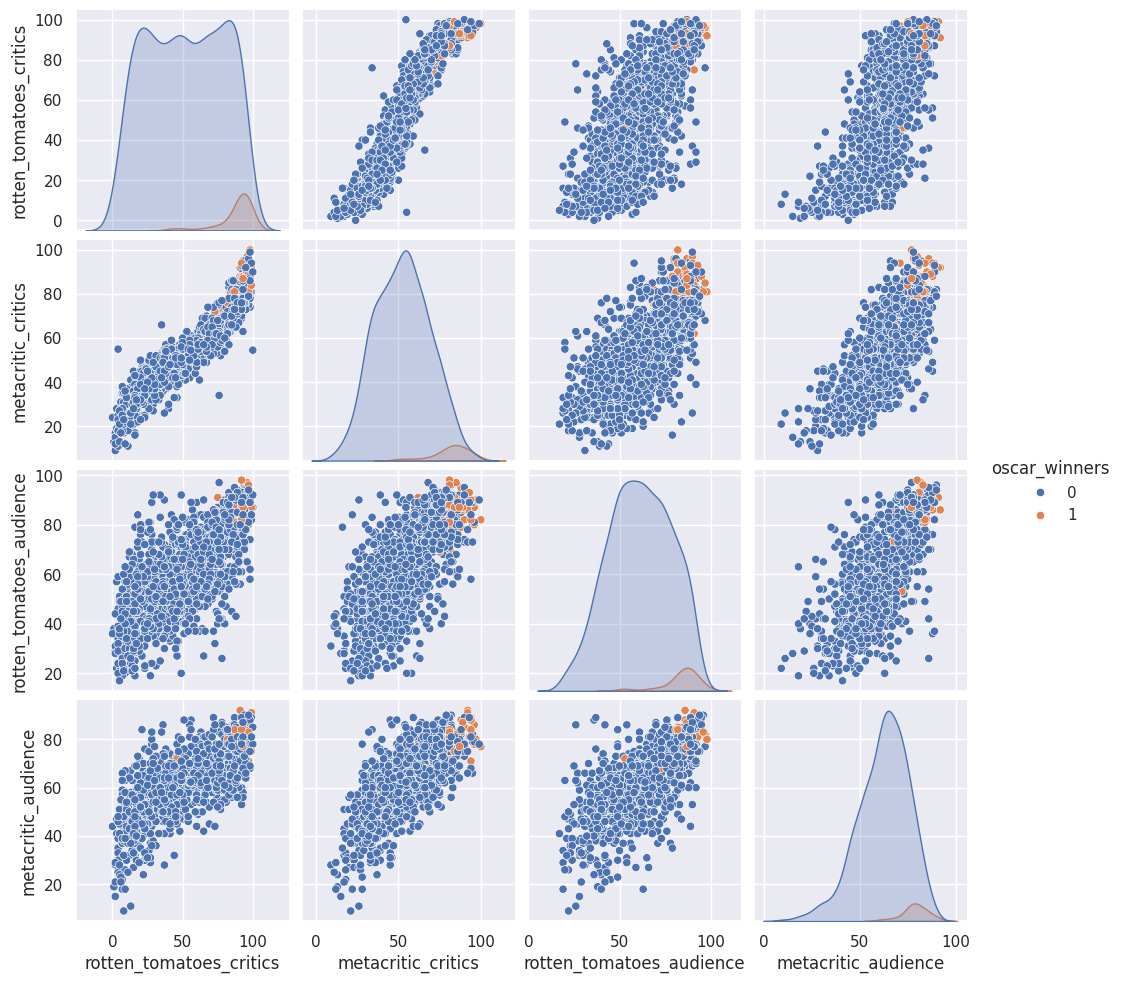

In [32]:
y = df_cl[['oscar_winners']]
# meta = df_cl['film'] 
pairplt = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]
sns.pairplot(pd.concat([pairplt, y], axis=1), hue='oscar_winners')
plt.show()

## 3.3 Principle Components Analysis
Εκτελούμε τον αλγόριθμο PCA για να δούμε αν τα δεδομένα μπορούν να αναπαρασταθούν σε λιγότερες διαστάσεις.

Επιλέγουμε τα πιο σημαντικά χαρακτηριστικά και υπολογίζουμε τις πιο σημαντικές διαστάσεις των Principal Components.

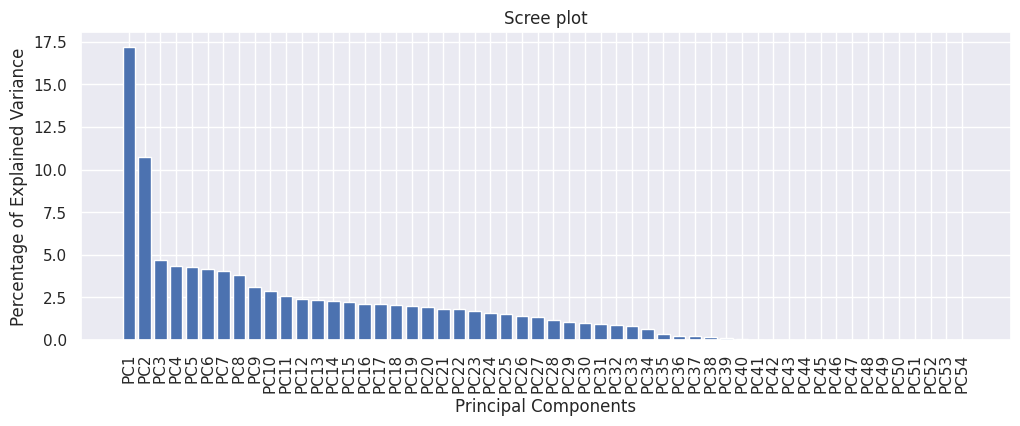

In [33]:
x = df_cl.drop(['film', 'year', 'distributor', 'distributor', 'imdb_rating',
       'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_winners',
       'oscar_detail'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

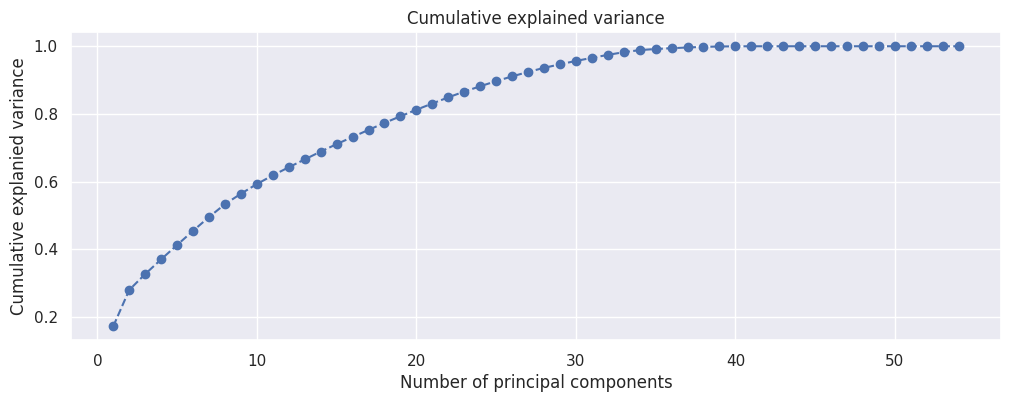

In [34]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

Μπορούμε να διακρίνουμε μία μικρή συσταδοποίηση των oscar winners κάνοντας plot τα πρώτα 2 principal components αλλά λόγω της πυκνότητας δεν έχουμε τα καλά αποτελέσματα.

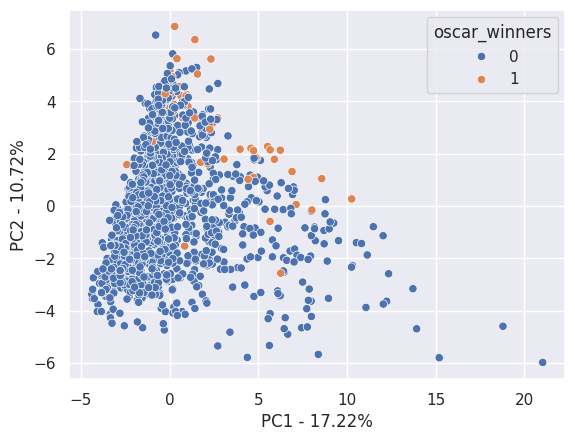

In [35]:
sns.set_theme()
# plt.figure(figsize=(8, 6))
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
sns.scatterplot(data=final_df, x="PC1", y='PC2', hue='oscar_winners')
plt.show()

Επαναϋπολογίζουμε τα principal components και αυτή τη φορά κρατάμε τα n πρώτα πιο σημαντικά.

In [36]:
# # Calculate PCA
# pca = PCA(n_components=10)
# principal_components = pca.fit_transform(x)

# # Concat PCA results to dataframe
# principal_components_df = pd.DataFrame(principal_components)
# principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
# df_cl = pd.concat([df_cl, principal_components_df], axis=1)

# 4. Συσταδοποίηση

## 4.1 KMeans
Χωρήσαμε τα χαρακτηριστικά σε δύο ομάδες. Τα οικονιμά χαρακτηριστικά και οι βαθμολογίες κριτών/κοινού. Στη συνέχεια εκτελέσαμε PCA στις δύο αυτές ομάδες και κάναμε plot τα PC1 και PC2.

### 4.1.1 KMeans - PCA - Economy features

In [37]:
x = df_cl[['opening_weekend',
       'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'foreign_gross', 'worldwide_gross', 'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']]

# x = df_cl[['opening_weekend_($million)',
#        'domestic_gross_($million)', 'foreign_gross_($million)',
#        'worldwide_gross_($million)',
#        'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
#        'budget_recovered_opening_weekend']]

# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}_economic' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

Εύρεση αριθμό συστάδων με την μέθοδο elbow

In [38]:
inertia = []
for i in range(2,11):
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(principal_components_df)
    inertia.append(kmeans_elbow.inertia_)

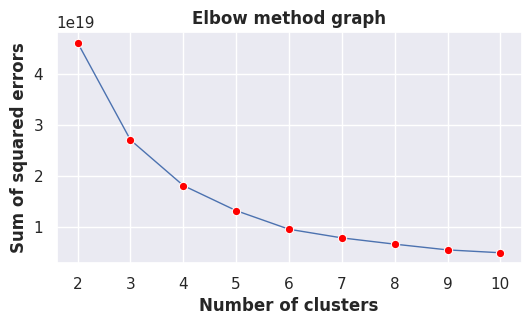

In [39]:
x = df_cl[['PC1_economic', 'PC2_economic']]

plt.figure(figsize=(6,3))
sns.set_theme()
ax = sns.lineplot(x = range(2,11), y = inertia, marker='o', markerfacecolor='red',linewidth=1)

ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})
plt.show()

Εκτελούμε την μεθοδο KMeans συσταδοποίηση με τον αριθμό των συστάδων που βρήκαμε παραπάνω.

In [40]:
# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=3, n_init='auto')
kmeans_pca.fit(df_cl[['PC1_economic', 'PC2_economic']])

#Append clusters to dataframe
df_cl['kmeans_pca_economic'] = kmeans_pca.labels_

In [41]:
# Count clusters
kmeans_dict_pca = dict(Counter(kmeans_pca.labels_))

#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans_pca_economic']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

print(f'KMeans clusters{kmeans_dict_pca} | oscars: {kmeans_oscars}')

KMeans clusters{2: 236, 0: 1088, 1: 78} | oscars: {2: 18, 0: 32, 1: 6}


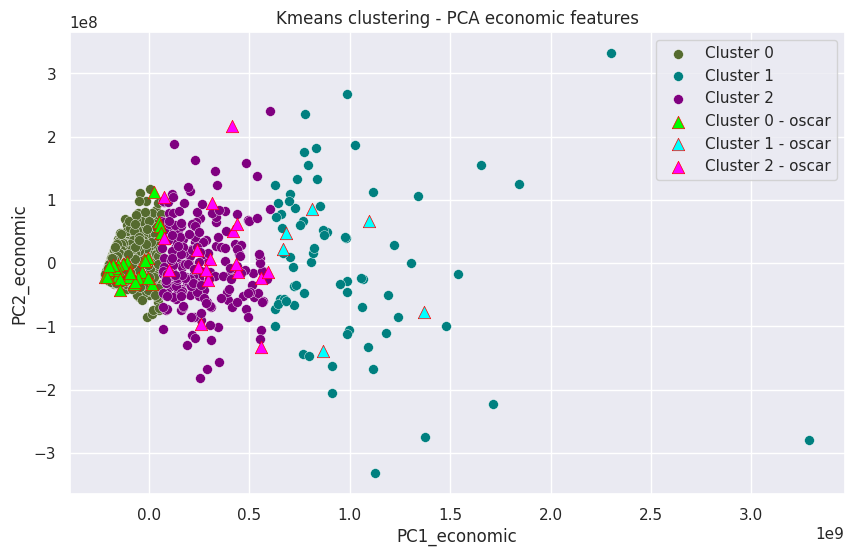

In [42]:
cluster_scatter_plot_2D(df_cl, clusters_column='kmeans_pca_economic', xfeature='PC1_economic', yfeature='PC2_economic', title='Kmeans clustering - PCA economic features')

### 4.1.2 KMeans - PCA Critics

In [43]:
x = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'rotten_tomatoes_vs_metacritic_deviance', 'average_audience',
       'audience_vs_critics_deviance']]

# Calculate PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}_critic' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

In [44]:
inertia = []
for i in range(2,11):
    kmeans_elbow = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans_elbow.fit(principal_components_df)
    inertia.append(kmeans_elbow.inertia_)

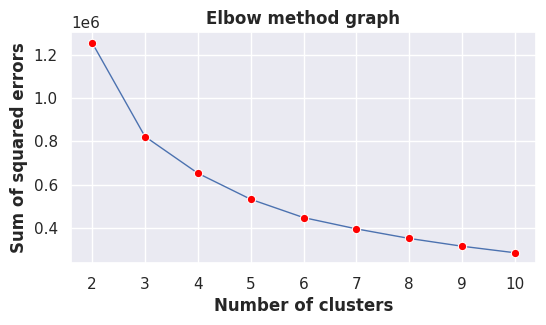

In [45]:
x = df_cl[['PC1_critic', 'PC2_critic']]

plt.figure(figsize=(6,3))
sns.set_theme()
ax = sns.lineplot(x = range(2,11), y = inertia, marker='o', markerfacecolor='red',linewidth=1)

ax.set(title='Elbow method graph', xlabel='Number of clusters', ylabel='Sum of squared errors')
ax.set_xlabel(ax.get_xlabel(), fontdict={'weight': 'bold'})
ax.set_ylabel(ax.get_ylabel(), fontdict={'weight': 'bold'})
ax.set_title(ax.get_title(), fontdict={'weight': 'bold'})
plt.show()

In [46]:
# Calculate KMeans clusters for PCA
kmeans_pca = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans_pca.fit(df_cl[['PC1_critic', 'PC2_critic']])

#Append clusters to dataframe
df_cl['kmeans_pca_critics'] = kmeans_pca.labels_

In [47]:
# Count clusters
kmeans_dict_pca = dict(Counter(kmeans_pca.labels_))

#Count Oscar winners in each cluster
kmeans_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], df_cl['kmeans_pca_critics']):
    if cluster not in kmeans_oscars:
        kmeans_oscars[cluster] = 0
    kmeans_oscars[cluster] += oscar

print(f'KMeans clusters{kmeans_dict_pca} | oscars: {kmeans_oscars}')

KMeans clusters{2: 521, 0: 407, 1: 474} | oscars: {2: 5, 0: 51, 1: 0}


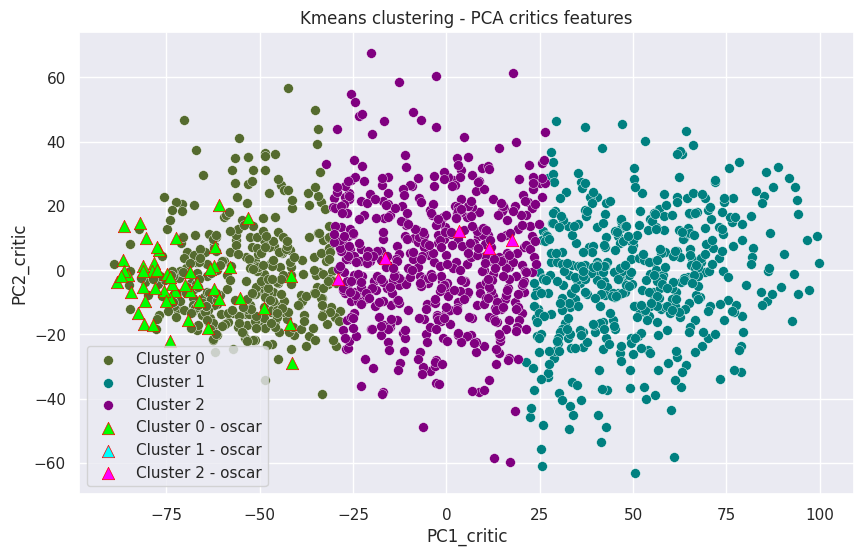

In [48]:
cluster_scatter_plot_2D(df_cl, clusters_column='kmeans_pca_critics', xfeature='PC1_critic', yfeature='PC2_critic', title='Kmeans clustering - PCA critics features')

### Συμπεράσματα kmeans - στατιστικά

#### Συστάδα 0 

Βαθμολογίες κριτικών / κοινού

In [49]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T


count       mean       std       min  \
rotten_tomatoes_critics                 407.0  86.282555  7.401322  66.00000   
metacritic_critics                      407.0  74.323169  9.139530  54.00000   
average_critics                         407.0  80.465290  7.818347  55.37289   
rotten_tomatoes_audience                407.0  80.093366  9.589923  43.00000   
metacritic_audience                     407.0  75.248157  7.022121  53.00000   
rotten_tomatoes_vs_metacritic_deviance  407.0   5.213759  9.310517 -19.00000   
average_audience                        407.0  77.687961  8.231244   7.00000   
audience_vs_critics_deviance            407.0   2.644737  9.087154 -18.00000   
oscar_winners                           407.0   0.125307  0.331474   0.00000   

                                         25%   50%   75%    max  
rotten_tomatoes_critics                 81.0  87.0  92.0  100.0  
metacritic_critics                      67.0  73.0  81.0  100.0  
average_critics                         75.0  80.0  86.0   99.0  
rotten_tomatoes_audience                74.0  82.0  87.0   98.0  
metacritic_audience                     71.0  76.0  80.0   92.0  
rotten_tomatoes_vs_metacritic_deviance   0.0   5.0  10.0   84.0  
average_audience                        73.0  79.0  84.0   93.0  
audience_vs_critics_deviance            -4.0   2.0   8.0   33.0  
oscar_winners                            0.0   0.0   0.0    1.0

Οικονομικά στοιχεία

In [50]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['opening_weekend_($million)',  
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

count         mean           std   min  \
opening_weekend_($million)        407.0    28.659337     40.428341  0.00   
domestic_gross_($million)         407.0   104.860246    125.796208  0.00   
foreign_gross_($million)          407.0  1856.592091  17699.217751  0.00   
worldwide_gross_($million)        407.0   238.621968    324.445090  0.00   
of_gross_earned_abroad            407.0    18.565921    176.992178  0.00   
budget_($million)                 407.0    61.923497     64.107709  0.12   
budget_recovered                  407.0  3637.897491  63875.439109  5.00   
budget_recovered_opening_weekend  407.0   372.872877   6474.868757  0.16   

                                        25%       50%       75%         max  
opening_weekend_($million)          1.50000   12.7600   39.0650      247.97  
domestic_gross_($million)          17.26000   59.1000  145.0150      936.66  
foreign_gross_($million)           13.61500   51.3700  208.1700   296402.00  
worldwide_gross_($million)         31.26000  113.0000  325.6400     2781.50  
of_gross_earned_abroad              0.13615    0.5137    2.0817     2964.02  
budget_($million)                  15.00000   33.0000   95.0000      260.00  
budget_recovered                  194.79000  334.2300  559.1300  1289066.67  
budget_recovered_opening_weekend   10.09500   30.8100   59.7750   130666.67

Είδη ταινίας

In [195]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_5469/1104439937.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_drama             106.0
gen_comedy             66.0
gen_action             57.0
gen_adventure          56.0
gen_thriller           50.0
gen_sci-fi             33.0
gen_animation          25.0
gen_crime              24.0
gen_romance            21.0
gen_fantasy            19.0
gen_biography          19.0
gen_horror             15.0
                      ...  
gen_history            11.0
gen_mystery             9.0
gen_musical             4.0
gen_war                 4.0
gen_sports              2.0
gen_western             2.0
gen_fanstasy            NaN
gen_holiday             NaN
gen_documentary         NaN
gen_period              NaN
gen_suspense            NaN
gen_horror/mystery      NaN
Name: 1, Length: 25, dtype: float64

In [54]:
df_cl[(df_cl['kmeans_pca_critics'] == 0)][['st_adaptation',
       'st_remake', 'st_original screenplay', 'st_reboot', 'st_documentary',
       'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_2174130/1101740064.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      104.0
st_adaptation                85.0
st_based on a true story     58.0
st_sequel                    36.0
st_remake                     5.0
st_reboot                     4.0
st_documentary                NaN
st_semi-sequel                NaN
st_prequel                    NaN
Name: 1, dtype: float64

#### Συστάδα 1

Βαθμολογίες κριτικών / κοινού

In [196]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T

count       mean        std   min  \
rotten_tomatoes_critics                 474.0  21.620253   9.996156   0.0   
metacritic_critics                      474.0  35.073840   8.118105   9.0   
average_critics                         474.0  28.564346   8.376359   6.0   
rotten_tomatoes_audience                474.0  47.725738  13.324566  17.0   
metacritic_audience                     474.0  50.421941  11.714324   9.0   
rotten_tomatoes_vs_metacritic_deviance  474.0  -2.696203  13.958581 -44.0   
average_audience                        474.0  49.305907  10.442447  15.5   
audience_vs_critics_deviance            474.0 -20.970464  10.056246 -48.0   
oscar_winners                           474.0   0.000000   0.000000   0.0   

                                         25%   50%    75%   max  
rotten_tomatoes_critics                 14.0  21.0  29.00  46.0  
metacritic_critics                      30.0  36.0  41.00  55.0  
average_critics                         23.0  29.0  35.00  47.0  
rotten_tomatoes_audience                39.0  48.0  56.00  90.0  
metacritic_audience                     44.0  51.0  58.00  84.0  
rotten_tomatoes_vs_metacritic_deviance -12.0  -4.0   4.75  45.0  
average_audience                        43.0  50.0  56.00  78.0  
audience_vs_critics_deviance           -28.0 -22.0 -15.00  12.0  
oscar_winners                            0.0   0.0   0.00   0.0

Οικονομικά στοιχεία

In [51]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T


count        mean          std   min  \
opening_weekend_($million)        474.0   18.805127    19.103836  0.00   
domestic_gross_($million)         474.0   52.082173    51.096986  0.54   
foreign_gross_($million)          474.0   72.121329   107.860609  0.00   
worldwide_gross_($million)        474.0  122.329243   144.090808  1.00   
of_gross_earned_abroad            474.0    0.721213     1.078606  0.00   
budget_($million)                 474.0   51.252266    46.395697  0.10   
budget_recovered                  474.0  443.803481  1876.117263  7.75   
budget_recovered_opening_weekend  474.0   96.477068   488.915492  0.09   

                                        25%       50%         75%         max  
opening_weekend_($million)          8.01250   13.8750   22.527500    166.0100  
domestic_gross_($million)          21.30000   37.4700   64.202500    402.1000  
foreign_gross_($million)           12.32500   36.7600   84.977500    845.9700  
worldwide_gross_($million)         39.57250   76.2550  150.920000   1123.7900  
of_gross_earned_abroad              0.12325    0.3676    0.849775      8.4597  
budget_($million)                  20.00000   35.0000   69.000000    250.0000  
budget_recovered                  127.00000  221.4050  344.437500  38164.4100  
budget_recovered_opening_weekend   21.22750   35.1250   65.020000   9808.4600

Είδη ταινίας

In [198]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_5469/3334173668.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_comedy            98.0
gen_action            77.0
gen_thriller          50.0
gen_drama             43.0
gen_adventure         43.0
gen_horror            40.0
gen_romance           27.0
gen_sci-fi            22.0
gen_fantasy           22.0
gen_crime             16.0
gen_animation         11.0
gen_family             9.0
                      ... 
gen_war                3.0
gen_western            2.0
gen_history            1.0
gen_musical            1.0
gen_biography          1.0
gen_period             1.0
gen_sports             NaN
gen_fanstasy           NaN
gen_holiday            NaN
gen_documentary        NaN
gen_suspense           NaN
gen_horror/mystery     NaN
Name: 1, Length: 25, dtype: float64

In [55]:
df_cl[(df_cl['kmeans_pca_critics'] == 1)][['st_adaptation',
       'st_remake', 'st_original screenplay', 'st_reboot', 'st_documentary',
       'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_2174130/2733431026.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      113.0
st_adaptation                76.0
st_sequel                    57.0
st_remake                     7.0
st_based on a true story      6.0
st_reboot                     4.0
st_documentary                NaN
st_semi-sequel                NaN
st_prequel                    NaN
Name: 1, dtype: float64

#### Συστάδα 2

Βαθμολογίες κριτικών / κοινού

In [199]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['rotten_tomatoes_critics', 'metacritic_critics', 'average_critics', 'rotten_tomatoes_audience', 'metacritic_audience',
                                            'rotten_tomatoes_vs_metacritic_deviance', 'average_audience','audience_vs_critics_deviance', 'oscar_winners']].describe().T

count       mean        std   min  \
rotten_tomatoes_critics                 521.0  56.285182  11.475284  26.0   
metacritic_critics                      521.0  54.583607   6.417541  33.0   
average_critics                         521.0  55.666499   8.259446  37.0   
rotten_tomatoes_audience                521.0  61.188295  11.942036  20.0   
metacritic_audience                     521.0  64.577061   7.801889  42.0   
rotten_tomatoes_vs_metacritic_deviance  521.0  -3.507385  11.989239 -60.0   
average_audience                        521.0  63.113808   8.183310  38.0   
audience_vs_critics_deviance            521.0  -7.584983  11.212743 -42.0   
oscar_winners                           521.0   0.009597   0.097586   0.0   

                                         25%   50%   75%   max  
rotten_tomatoes_critics                 47.0  56.0  66.0  83.0  
metacritic_critics                      50.0  55.0  59.0  76.0  
average_critics                         49.0  55.0  62.0  76.0  
rotten_tomatoes_audience                54.0  62.0  70.0  92.0  
metacritic_audience                     60.0  65.0  70.0  89.0  
rotten_tomatoes_vs_metacritic_deviance -10.0  -3.0   3.0  34.0  
average_audience                        58.0  63.0  69.0  83.0  
audience_vs_critics_deviance           -15.0  -8.0  -1.0  30.0  
oscar_winners                            0.0   0.0   0.0   1.0

Οικονομικά στοιχεία

In [56]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['opening_weekend_($million)',
       'domestic_gross_($million)', 'foreign_gross_($million)',
       'worldwide_gross_($million)',
       'of_gross_earned_abroad', 'budget_($million)', 'budget_recovered',
       'budget_recovered_opening_weekend']].describe().T

count         mean           std   min  \
opening_weekend_($million)        521.0    22.934587     23.379319  0.00   
domestic_gross_($million)         521.0    69.989021     68.161567  0.97   
foreign_gross_($million)          521.0  1286.798733  21820.226936  0.00   
worldwide_gross_($million)        521.0   167.858804    201.338768  1.00   
of_gross_earned_abroad            521.0    12.867987    218.202269  0.00   
budget_($million)                 521.0    57.181849     55.232953  0.20   
budget_recovered                  521.0   411.554009    753.449436  8.19   
budget_recovered_opening_weekend  521.0    69.698304    140.369126  0.05   

                                      25%      50%       75%        max  
opening_weekend_($million)          8.300   16.070   29.8000     151.12  
domestic_gross_($million)          24.340   48.090   93.4400     367.23  
foreign_gross_($million)           11.200   46.300  119.1400  489121.00  
worldwide_gross_($million)         40.540   94.880  211.3400    1235.76  
of_gross_earned_abroad              0.112    0.463    1.1914    4891.21  
budget_($million)                  20.000   37.000   75.0000     300.00  
budget_recovered                  149.780  254.820  416.2600   12074.08  
budget_recovered_opening_weekend   22.020   39.520   62.5000    1802.50

Είδη ταινίας

In [201]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_5469/2827174932.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama']].apply(pd.value_counts).T[1].sort_values(ascending=False)


gen_comedy            99.0
gen_drama             84.0
gen_action            74.0
gen_thriller          65.0
gen_adventure         55.0
gen_sci-fi            31.0
gen_horror            29.0
gen_crime             29.0
gen_fantasy           25.0
gen_animation         25.0
gen_romance           24.0
gen_family            22.0
                      ... 
gen_biography          7.0
gen_history            4.0
gen_musical            4.0
gen_war                3.0
gen_documentary        2.0
gen_western            1.0
gen_sports             NaN
gen_fanstasy           NaN
gen_holiday            NaN
gen_period             NaN
gen_suspense           NaN
gen_horror/mystery     NaN
Name: 1, Length: 25, dtype: float64

In [53]:
df_cl[(df_cl['kmeans_pca_critics'] == 2)][['st_adaptation',
       'st_remake', 'st_original screenplay', 'st_reboot', 'st_documentary',
       'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)

/tmp/ipykernel_2174130/3227833518.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  'st_based on a true story', 'st_semi-sequel', 'st_sequel', 'st_prequel']].apply(pd.value_counts).T[1].sort_values(ascending=False)


st_original screenplay      114.0
st_adaptation               109.0
st_sequel                    55.0
st_based on a true story     19.0
st_remake                    11.0
st_reboot                    10.0
st_prequel                    1.0
st_documentary                NaN
st_semi-sequel                NaN
Name: 1, dtype: float64

## 4.3 Agglomerative Clustering
Εκτελούμε τον αλγόριθμο συσταδοποίησης Agglomerative σε επιλεγμένα χαρακτηριστικά.

Scatterplot για το Agglomerative Clustering.

### My approach

In [202]:
df_agg = df_cl.drop(['film', 'year', 'distributor', 'distributor', 'imdb_rating',
       'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_winners',
       'oscar_detail'], axis=1)

In [203]:
# Calculate agglomerative clustering
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(df_agg)

agg_dict = dict(Counter(agg.labels_))

# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

print(agg_dict)
print(agg_oscars)

{1: 146, 0: 1256}
{1: 15, 0: 41}


In [204]:
df_agg = df_cl[['rotten_tomatoes_critics', 'metacritic_critics', 'rotten_tomatoes_audience', 'metacritic_audience']]

In [205]:
# Calculate agglomerative clustering
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(df_agg)

agg_dict = dict(Counter(agg.labels_))

# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

print(agg_dict)
print(agg_oscars)

{0: 839, 1: 563}
{0: 3, 1: 53}


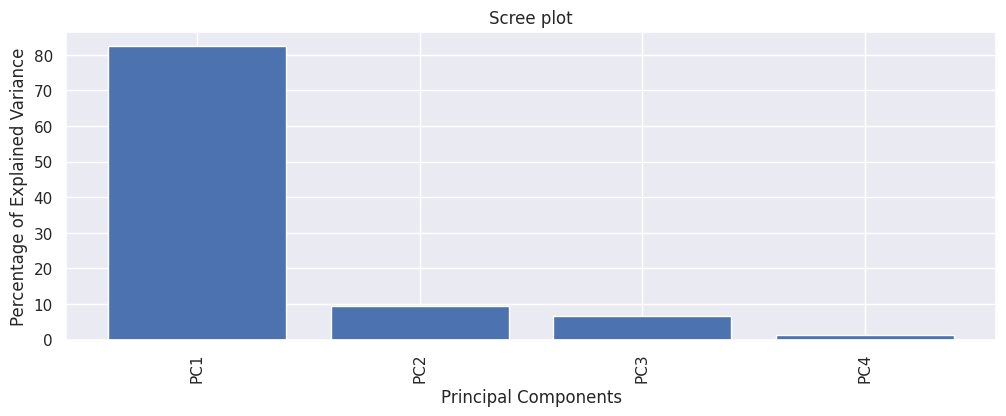

In [206]:
x = df_agg
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_agg_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

In [207]:
# Calculate agglomerative clustering
final_agg_df = final_agg_df.drop(['PC3', 'PC4'], axis=1)
x = final_agg_df.drop(['oscar_winners'], axis=1)

agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg.fit(x)

agg_dict = dict(Counter(agg.labels_))
df_cl['agglomerative'] = agg.labels_
# Count oscar winners in each cluster
agg_oscars = {}
for oscar, cluster in zip(df_cl['oscar_winners'], agg.labels_):
    if cluster not in agg_oscars:
        agg_oscars[cluster] = 0
    agg_oscars[cluster] += oscar

print(agg_dict)
print(agg_oscars)

{0: 1053, 1: 349}
{0: 5, 1: 51}


In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=final_agg_df['PC1'], y=final_agg_df['PC2'], hue=df_cl['agglomerative'], palette='viridis')

oscar_winners_pca = final_agg_df[final_agg_df['oscar_winners'] == 1]
plt.scatter(oscar_winners_pca['PC1'], oscar_winners_pca['PC2'], color='red', marker='*', s=25 , label='Oscar Winners')

plt.title('Agglomerative Clustering with PCA (Oscar Winners Highlighted)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [ ]:
# cluster_scatter_plot_2D(df_cl, clusters_column='agglomerative', xfeature='PC1_critic', yfeature='PC2_critic', title='Agglomerative clustering')

## 4.4 Αξιολόγηση αλγόριθμων συσταδοποίησης



- KMeans Clustering

In [ ]:
# Define datasets for each KMeans clustering
X_kmeans_pca = df_kmeans_pca
X_kmeans_critics = df_kmeans
X_kmeans_audience = df_audience_features

# Function to evaluate clustering
def evaluate_clustering(X, labels, clustering_name):
    silhouette = silhouette_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)

    print(f"{clustering_name} Evaluation")
    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print(f"Davies-Bouldin Index: {davies_bouldin}\n")

# Evaluating KMeans clusterings
evaluate_clustering(X_kmeans_pca, df_cl['kmeans_pca'], "KMeans PCA")
evaluate_clustering(X_kmeans_critics, df_cl['kmeans'], "KMeans Critics")
evaluate_clustering(X_kmeans_audience, df_cl['kmeans_audience'], "KMeans Audience")

KMeans PCA Evaluation
Silhouette Score: 0.4389228689555876
Calinski-Harabasz Index: 1389.6714521121023
Davies-Bouldin Index: 0.7646472344262609

KMeans Critics Evaluation
Silhouette Score: 0.5002010782876959
Calinski-Harabasz Index: 4813.418625852946
Davies-Bouldin Index: 0.6038780529166075

KMeans Audience Evaluation
Silhouette Score: 0.37752323975040425
Calinski-Harabasz Index: 1779.1423064854275
Davies-Bouldin Index: 0.8831512153112048



- DBSCAN Clustering


In [ ]:
mask = df_cl['dbscan'] != -1
silhouette_dbscan = silhouette_score(X_dbscan[mask], df_cl.loc[mask, 'dbscan'])
calinski_harabasz_dbscan = calinski_harabasz_score(X_dbscan[mask], df_cl.loc[mask, 'dbscan'])
davies_bouldin_dbscan = davies_bouldin_score(X_dbscan[mask], df_cl.loc[mask, 'dbscan'])

print("\nDBSCAN Clustering Evaluation")
print(f"Silhouette Score: {silhouette_dbscan}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_dbscan}")
print(f"Davies-Bouldin Index: {davies_bouldin_dbscan}")


DBSCAN Clustering Evaluation
Silhouette Score: 0.3382894582384262
Calinski-Harabasz Index: 48.329249445568536
Davies-Bouldin Index: 0.5180020048441863


- Agglomerative Clustering


In [ ]:
silhouette_agglo = silhouette_score(X_aglm, df_cl['agg'])
calinski_harabasz_agglo = calinski_harabasz_score(X_aglm, df_cl['agg'])
davies_bouldin_agglo = davies_bouldin_score(X_aglm, df_cl['agg'])

print("Agglomerative Clustering Evaluation")
print(f"Silhouette Score: {silhouette_agglo}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_agglo}")
print(f"Davies-Bouldin Index: {davies_bouldin_agglo}")

Agglomerative Clustering Evaluation
Silhouette Score: 0.47726851035018075
Calinski-Harabasz Index: 2068.533510134978
Davies-Bouldin Index: 0.7119733883363499


--- 

Aξιολογούμε την απόδοση τριών διαφορετικών αλγορίθμων ομαδοποίησης: KMeans (εφαρμόζεται σε χαρακτηριστικά PCA, βαθμολογίες κριτικών και βαθμολογίες κοινού), DBSCAN και Agglomerative Clustering. Η αξιολόγηση βασίζεται σε τρεις βασικές μετρήσεις: Δείκτης Silhouette, Δείκτης Calinski-Harabasz και Δείκτης Davies-Bouldin. Αυτές οι μετρήσεις παρέχουν πληροφορίες για την πυκνότητα, τον διαχωρισμό και τη διακριτότητα των συστάδων που σχηματίζονται από κάθε αλγόριθμο.

Πιο συγκεκριμένα: 

- Βαθμολογία Silhouette: Μετρά πόσο παρόμοιο είναι ένα αντικείμενο με το δικό του σύμπλεγμα σε σύγκριση με άλλα συμπλέγματα. Μια υψηλότερη βαθμολογία υποδηλώνει καλύτερη συνοχή και διαχωρισμό συστάδων.
- Δείκτης Calinski-Harabasz: Αξιολογεί συστάδες με βάση τη μέση διακύμανση μεταξύ των κλάδων διαιρούμενων με τη διακύμανση εντός της κάθε "ομάδας". Οι υψηλότερες βαθμολογίες υποδηλώνουν καλύτερα καθορισμένες ομάδες.
- Δείκτης Davies-Bouldin: Μετρά τη μέση ομοιότητα μεταξύ κάθε συστάδας και της πιο παρόμοιας συστάδας. Οι χαμηλότερες τιμές υποδηλώνουν καλύτερη ομαδοποίηση.

Προς διευκολία ερμήνευσης των αποτελεσμάτων, κάνουμε το παρακάτω bar graph:

In [ ]:
# Data preparation
methods = ['KMeans (PCA)', 'KMeans (Critics)', 'KMeans (Audience)', 'DBSCAN', 'Agglomerative']
silhouette_scores = [0.4396, 0.5012, 0.3768, 0.3383, 0.4857]
calinski_scores = [1410.003, 4816.516, 1779.594, 48.326, 2182.376]
davies_scores = [0.7714, 0.6035, 0.8814, 0.5180, 0.7225]
colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(15, 5))

# Silhouette Score plot
plt.subplot(1, 3, 1)
for i, method in enumerate(methods):
    plt.bar(method, silhouette_scores[i], color=colors[i])
plt.title('Silhouette Scores (Higher is better)')
plt.xticks(rotation=45)

# Calinski-Harabasz plot
plt.subplot(1, 3, 2)
for i, method in enumerate(methods):
    plt.bar(method, calinski_scores[i], color=colors[i])
plt.title('Calinski-Harabasz Index (Higher is better)')
plt.xticks(rotation=45)

# Davies-Bouldin plot
plt.subplot(1, 3, 3)
for i, method in enumerate(methods):
    plt.bar(method, davies_scores[i], color=colors[i])
plt.title('Davies-Bouldin Index (Lower is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Ομαδοποίηση KMeans:

- Οι βαθμολογίες KMeans για τους Critics ξεπέρασαν τις άλλες μεθόδους KMeans με τον υψηλότερο δείκτη Calinski-Harabasz, υποδεικνύοντας εξαιρετικά πυκνά και καλά διαχωρισμένα συμπλέγματα. Πέτυχε επίσης τον χαμηλότερο δείκτη Davies-Bouldin, υποδηλώνοντας ελάχιστη επικάλυψη (overlap) μεταξύ των συστάδων.

- Το KMeans στα χαρακτηριστικά PCA παρουσίασε μέτρια απόδοση, υποδεικνύοντας εύλογο σχηματισμό συμπλέγματος, αλλά με περιθώρια βελτίωσης στον διαχωρισμό και τη συνοχή.

- Οι βαθμολογίες KMeans στο Audience παρουσίασαν χαμηλότερη απόδοση, ιδιαίτερα όσον αφορά τη βαθμολογία Silhouette, υποδηλώνοντας λιγότερο ευδιάκριτη ομαδοποίηση.

Ομαδοποίηση DBSCAN:

- Το DBSCAN είχε τον χαμηλότερο δείκτη Calinski-Harabasz, υποδεικνύοντας λιγότερο πυκνά και κακώς διαχωρισμένα συμπλέγματα, κάτι που είναι κοινό χαρακτηριστικό του DBSCAN όταν ασχολείται με δεδομένα υψηλών διαστάσεων ή λιγότερο ευδιάκριτα. Ωστόσο, πέτυχε έναν σχετικά χαμηλό δείκτη Davies-Bouldin, υποδεικνύοντας εύλογο διαχωρισμό μεταξύ των συστάδων.

Ομαδοποίηση Agglomerative:

- Αυτή η μέθοδος έδειξε ισχυρή ισορροπία σε όλες τις μετρήσεις, με την υψηλότερη βαθμολογία Silhouette μεταξύ όλων των μεθόδων, υποδηλώνοντας καλή συνοχή και διαχωρισμό συμπλέγματος.

---

Συμπεράσματα:

- Το KMeans με βαθμολογίες Critics φαίνεται να είναι η πιο αποτελεσματική μέθοδος για αυτό το συγκεκριμένο σύνολο δεδομένων, ιδιαίτερα όταν η πυκνότητα και ο διαχωρισμός συμπλέγματος είναι πρωταρχικής σημασίας.

- Η Agglomerative ομαδοποίηση είναι ένας ισχυρός υποψήφιος, ειδικά για σενάρια όπου η συνοχή των συστάδων είναι κρίσιμη.

- Το DBSCAN μπορεί να απαιτεί συντονισμό παραμέτρων ή μπορεί να μην είναι το ίδιο κατάλληλο για αυτό το σύνολο δεδομένων, δεδομένης της χαμηλότερης απόδοσής του σε βασικές μετρήσεις.

# 5. Μοντέλα προβλέψεων

## 5.1 Επιλογή χαρακτηριστικών και PCA

### 5.1.1 Σύνολο εκπαίδευσης

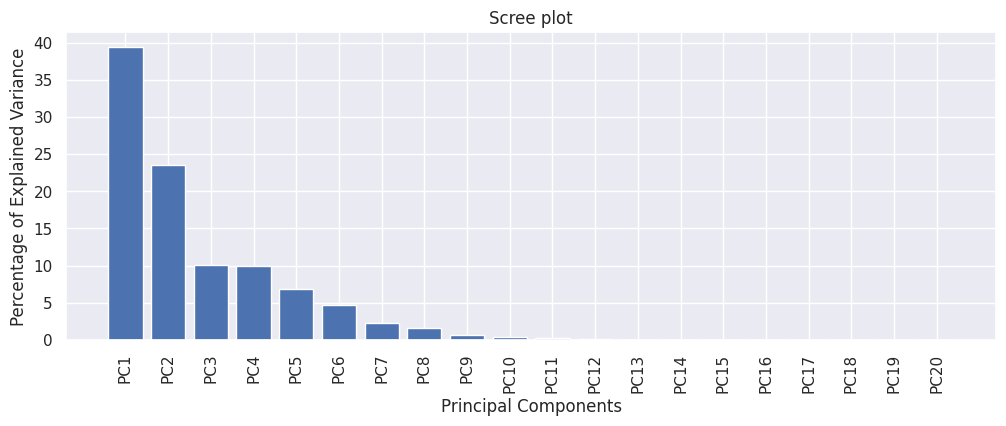

In [ ]:
x = df_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
       'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
       'st_documentary', 'st_reboot', 'st_based on a true story',
       'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

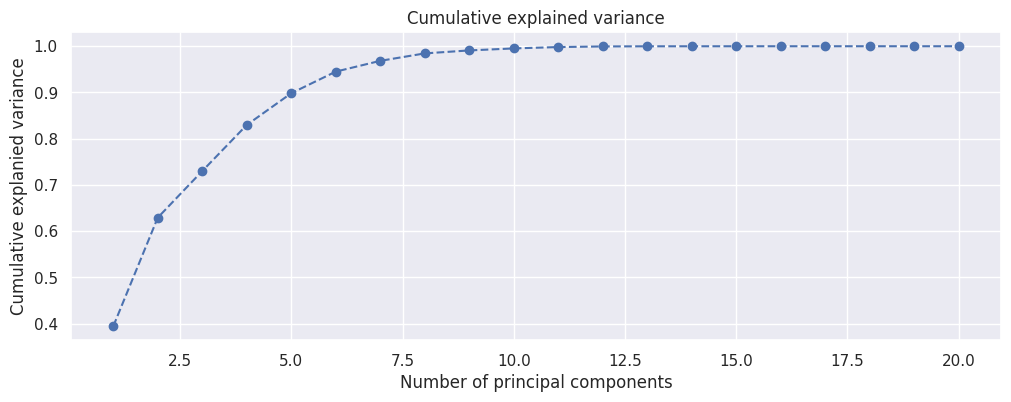

In [ ]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [ ]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

### 5.1.2 Άγνωστο σύνολο και PCA

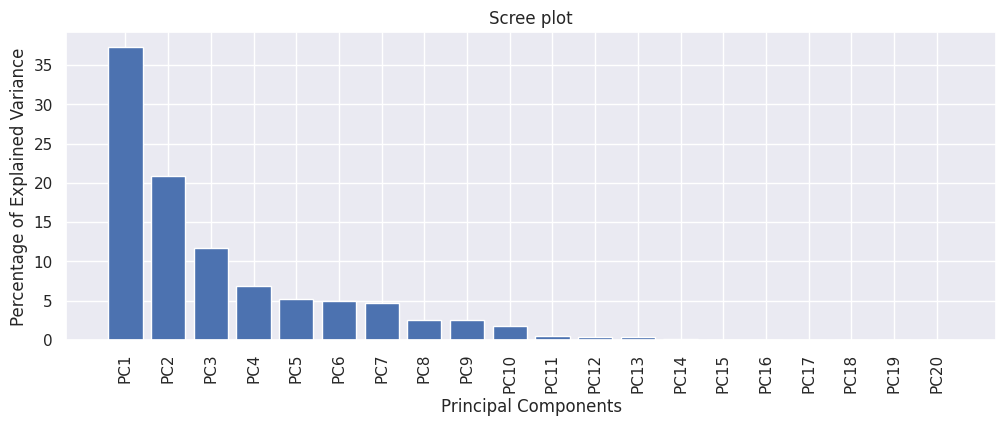

In [ ]:
# x = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
x = df_un_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
       'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
       'st_documentary', 'st_reboot', 'st_based on a true story',
       'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

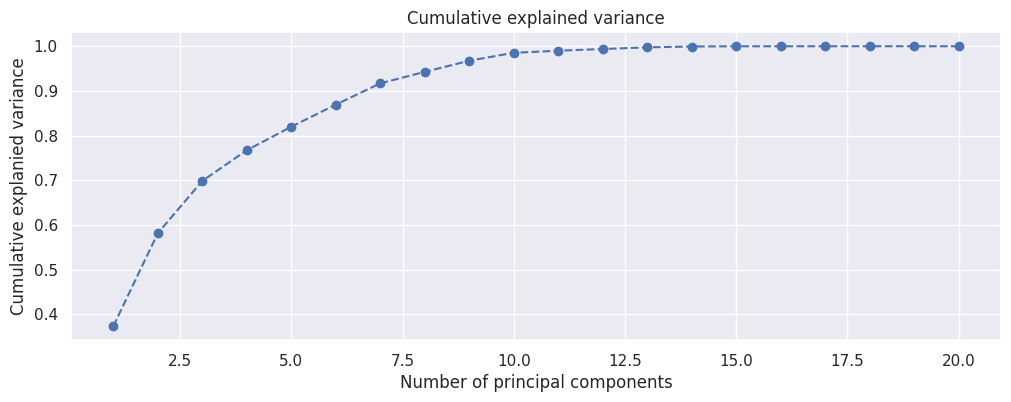

In [ ]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [ ]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_un_cl = pd.concat([df_un_cl, principal_components_df], axis=1)

## 5.2 Εύρεση υπερπαραμέτρων με την τεχνική Grid Search Cross Validation

### 5.2.1 ADA Boost

In [ ]:
# Select PCA components
df = df_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'oscar_winners']]
train_datasets, test_dataset = build_resampled_datasets(df, test_ratio=0.3)

Define results dict

In [ ]:
results = {}

In [ ]:
#Ada boost
results['ADA'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['ADA'][sampling] = []

    model = AdaBoostClassifier(random_state=1)
    
    # Full search
    parameters = {
            'n_estimators': range(10, 2001, 10),
    }    

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['ADA'][sampling] = {
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        }
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for default: {'n_estimators': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for upsampled: {'n_estimators': 980}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for downsampled: {'n_estimators': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for SMOTE: {'n_estimators': 980}


In [ ]:
# params= {}
# for sampling in results['ADA']:
#     params[sampling] = results['ADA'][sampling][0]['params'] 

# with open("./ADA.json", 'w') as f:
#     json.dump(params, f)    

### 5.2.2 Gradient Boost

In [ ]:
# Gradient boosting classifier
results['GRB'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['GRB'][sampling] = []

    model = GradientBoostingClassifier(random_state=1) 

    # Full search
    parameters = {
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        "min_samples_split": np.linspace(0.1, 0.5, 12),
        "min_samples_leaf": np.linspace(0.1, 0.5, 12),
        "max_depth":[3,5,8],
        "max_features":["log2","sqrt"],
        "criterion": ["friedman_mse",  "squared_error"],
        "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        "n_estimators":[10]
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['GRB'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters for default: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.9}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for upsampled: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.9}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for downsampled: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.9}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SMOTE: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454

In [ ]:
# params= {}
# for sampling in results['GRB']:
#     params[sampling] = results['GRB'][sampling][0]['params'] 

# with open("./test.json", 'w') as f:
#     json.dump(params, f)    

### 5.2.4 Decision Tree

In [ ]:
# Decision tree classifier
results['DT'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['DT'][sampling] = []

    model = DecisionTreeClassifier(random_state=1)    

    parameters = {
        "criterion": ['gini', 'entropy'],
        "splitter": ['best', 'random'],
        "max_depth": range(1, 11, 1),
        'min_samples_split' : range(2, 11, 1),
        'min_samples_leaf' : range(1, 6, 1),
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['DT'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

In [ ]:
params= {}
for sampling in results['DT']:
    params[sampling] = results['DT'][sampling][0]['params'] 

with open("./DT.json", 'w') as f:
    json.dump(params, f)   

### 5.2.5 Random Forest

In [ ]:
# Random forest
results['RF'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['RF'][sampling] = []

    model = RandomForestClassifier(n_jobs=-1, random_state=1)

    parameters = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['log2', 'sqrt', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['RF'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 5940 candidates, totalling 29700 fits
Best parameters for default: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits
Best parameters for upsampled: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits
Best parameters for downsampled: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
Fitting 5 folds for each of 5940 candidates, totalling 29700 fits
Best parameters for SMOTE: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1400}


In [ ]:
params= {}
for sampling in results['RF']:
    params[sampling] = results['RF'][sampling][0]['params'] 

with open("./RF.json", 'w') as f:
    json.dump(params, f)   

### 5.2.6 K-Nearest Neighbors

In [ ]:
results['KNN'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['KNN'][sampling] = []

    model = KNeighborsClassifier(n_jobs=-1)

    parameters = {
        "n_neighbors": range(2, 21),
        "weights": ['uniform', 'distance'],
        "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size' : range(1, 201, 10)
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['KNN'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

    

Fitting 5 folds for each of 3040 candidates, totalling 15200 fits


Best parameters for default: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'weights': 'distance'}
Fitting 5 folds for each of 3040 candidates, totalling 15200 fits
Best parameters for upsampled: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'weights': 'uniform'}
Fitting 5 folds for each of 3040 candidates, totalling 15200 fits
Best parameters for downsampled: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 8, 'weights': 'uniform'}
Fitting 5 folds for each of 3040 candidates, totalling 15200 fits
Best parameters for SMOTE: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'weights': 'uniform'}


In [ ]:
params= {}
for sampling in results['KNN']:
    params[sampling] = results['KNN'][sampling][0]['params'] 

with open("./KNN.json", 'w') as f:
    json.dump(params, f)    

## 5.3 Αποτελέσματα εκπαίδευσης

### 5.3.1 Αναφορά κατηγοριοποίησης του συνόλου δοκιμής

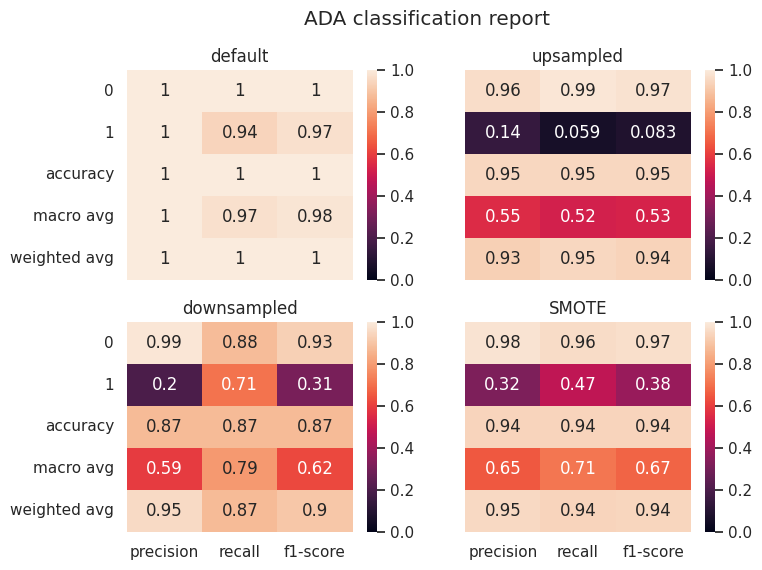

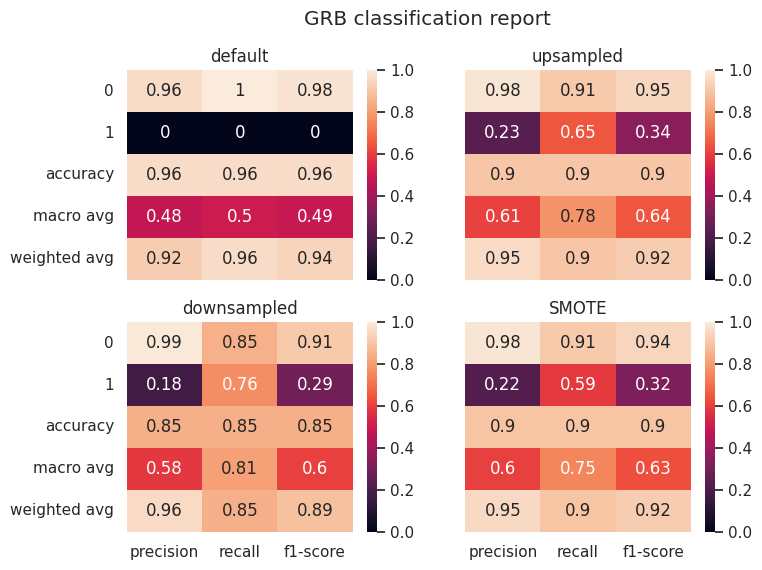

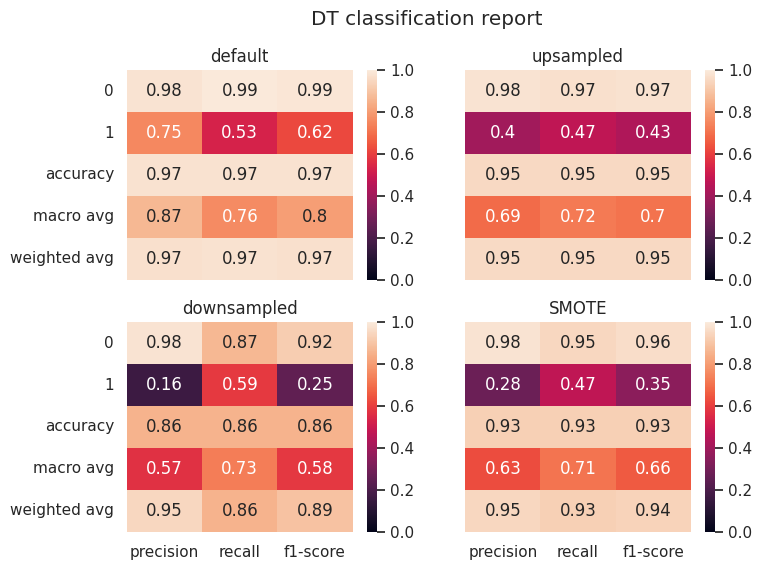

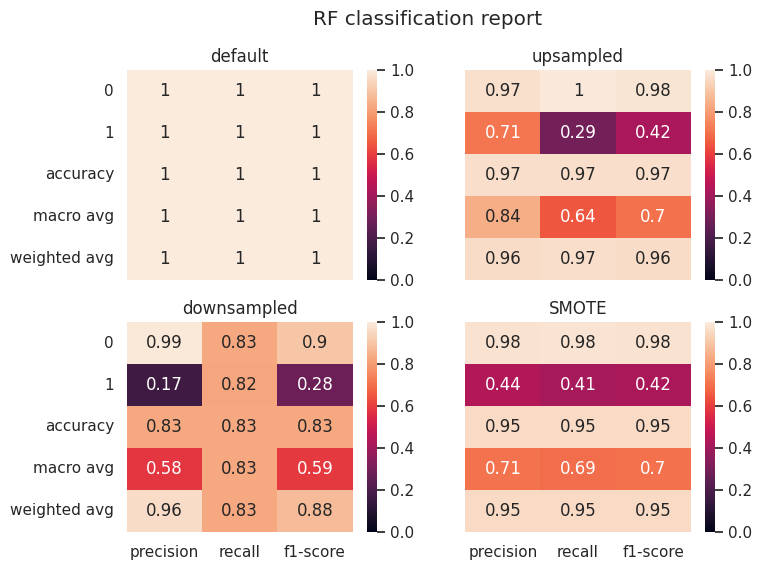

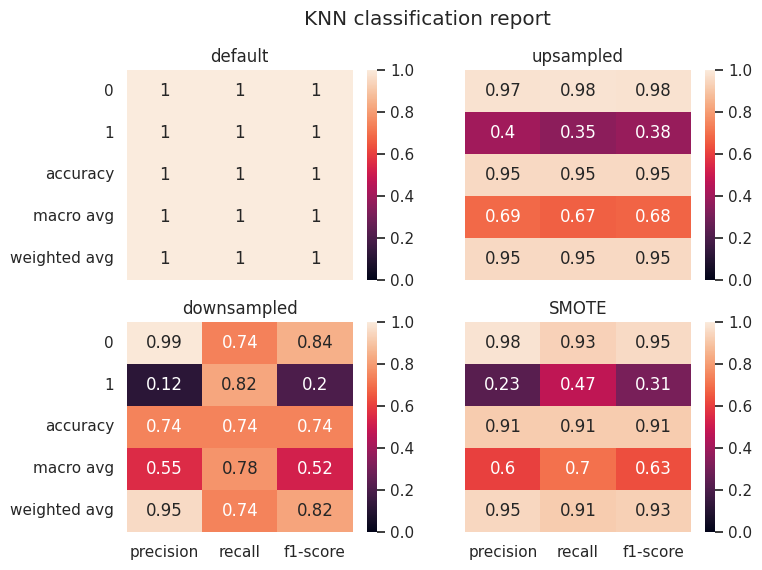

In [ ]:
plot_classification_reports_averages(results, 'ADA')
plot_classification_reports_averages(results, 'GRB')
plot_classification_reports_averages(results, 'DT')
plot_classification_reports_averages(results, 'RF')
plot_classification_reports_averages(results, 'KNN')

### 5.3.2 Καμπύλες ROC

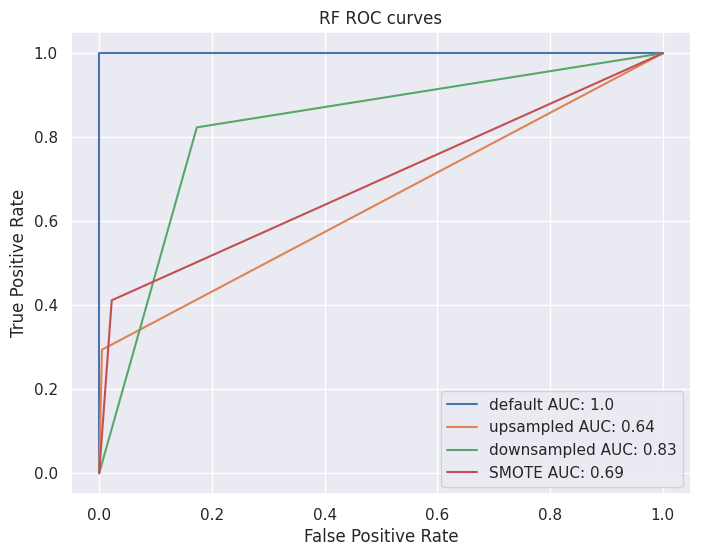

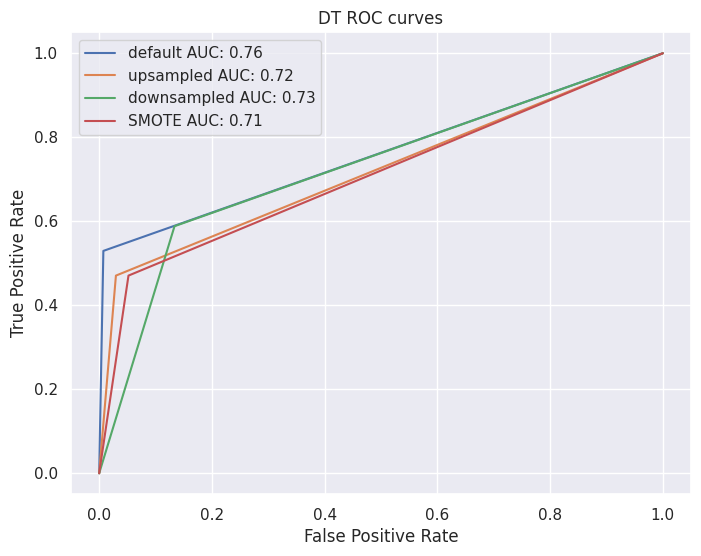

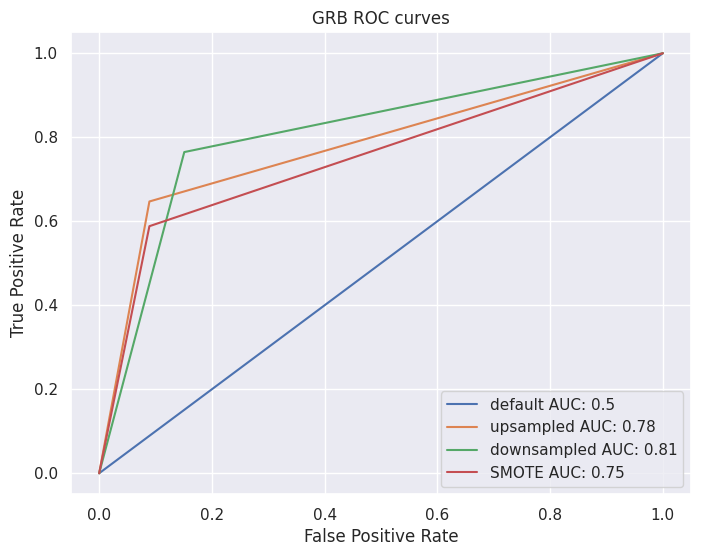

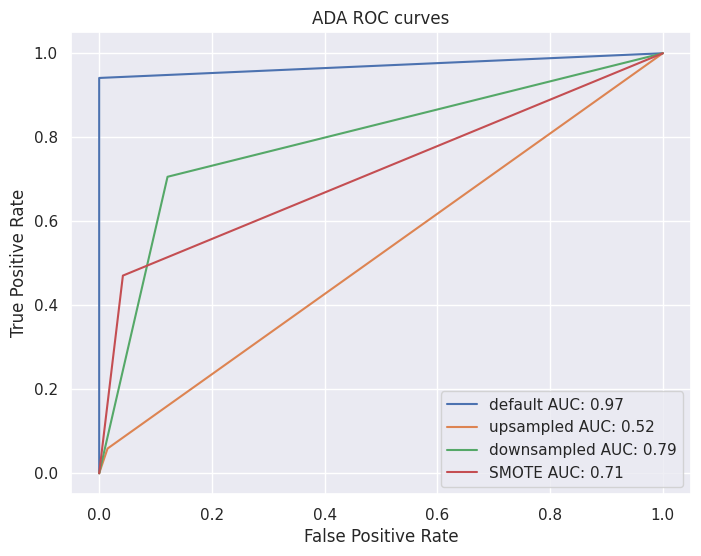

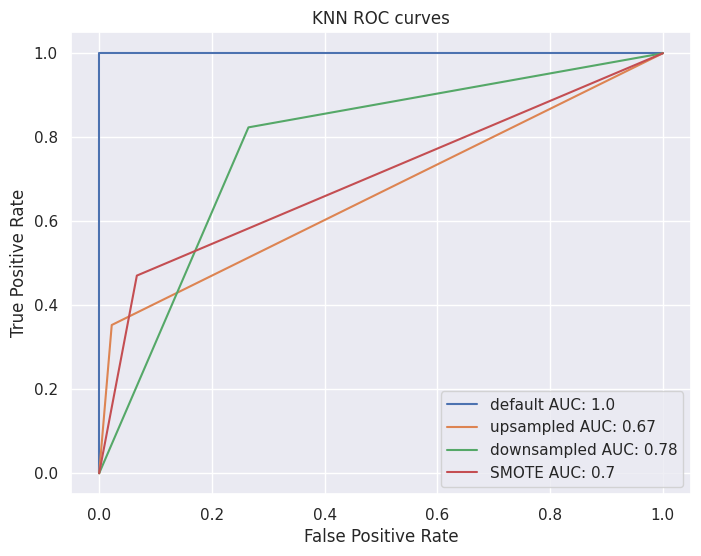

In [ ]:
best_f1_ada = best_f1_score_for_each_sampling_method(results, 'ADA')
best_f1_grb = best_f1_score_for_each_sampling_method(results, 'GRB')
best_f1_dt = best_f1_score_for_each_sampling_method(results, 'DT')
best_f1_rf = best_f1_score_for_each_sampling_method(results, 'RF')
best_f1_knn = best_f1_score_for_each_sampling_method(results, 'KNN')
plot_roc_curves(best_f1_rf, 'RF')
plot_roc_curves(best_f1_dt, 'DT')
plot_roc_curves(best_f1_grb, 'GRB')
plot_roc_curves(best_f1_ada, 'ADA')
plot_roc_curves(best_f1_knn, 'KNN')

### 5.3.3 Πίνακες σύγχησης

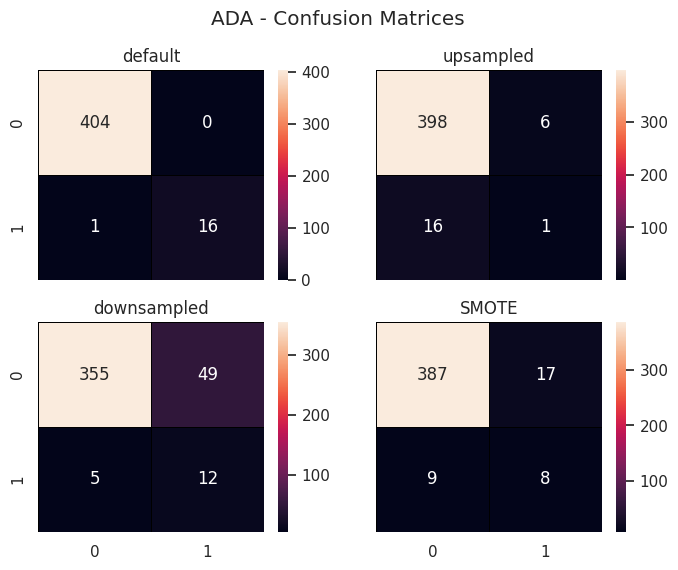

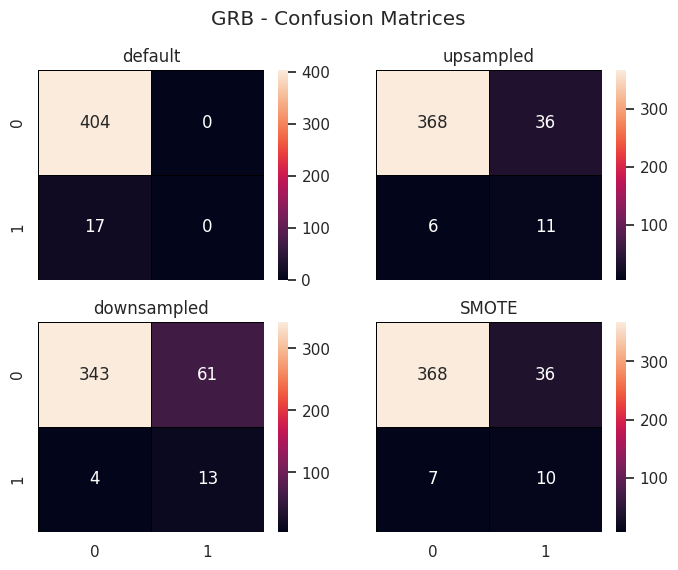

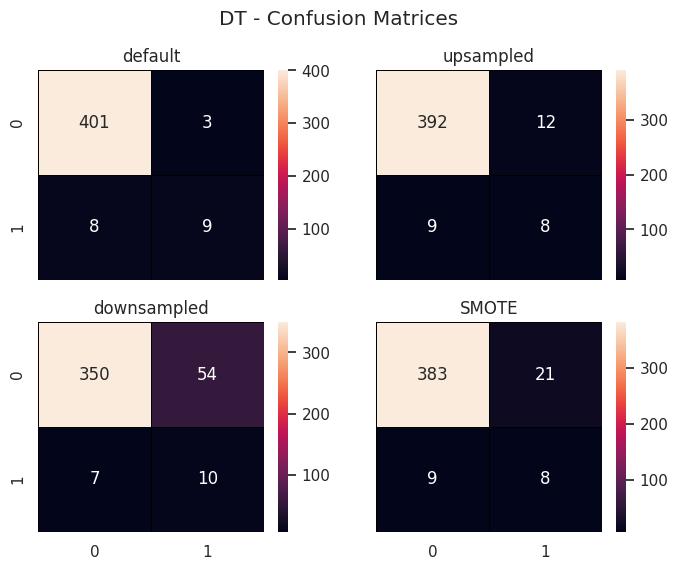

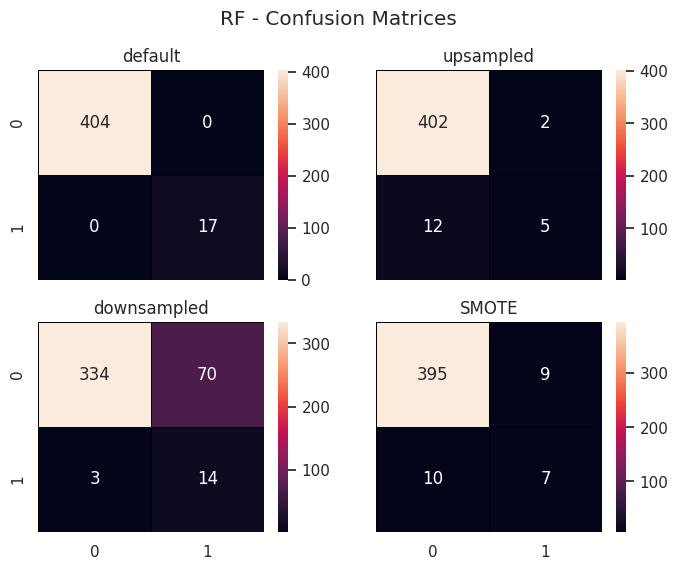

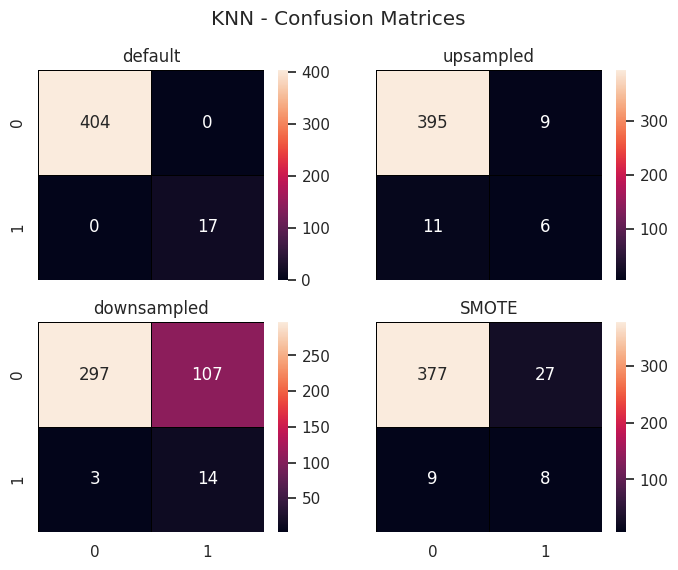

In [ ]:
plot_confusion_matrices(best_f1_ada, 'ADA')
plot_confusion_matrices(best_f1_grb, 'GRB')
plot_confusion_matrices(best_f1_dt, 'DT')
plot_confusion_matrices(best_f1_rf, 'RF')
plot_confusion_matrices(best_f1_knn, 'KNN')

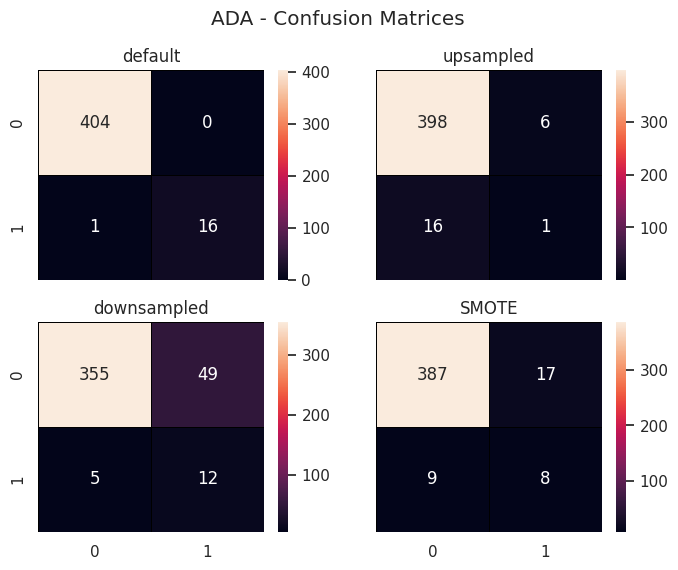

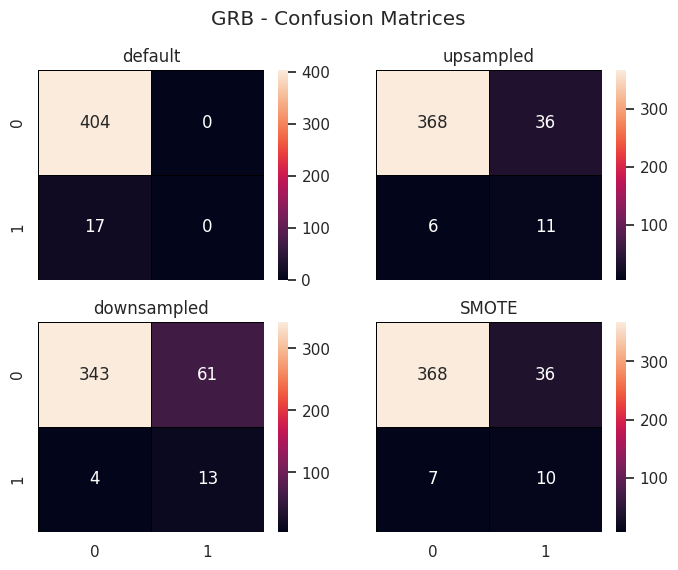

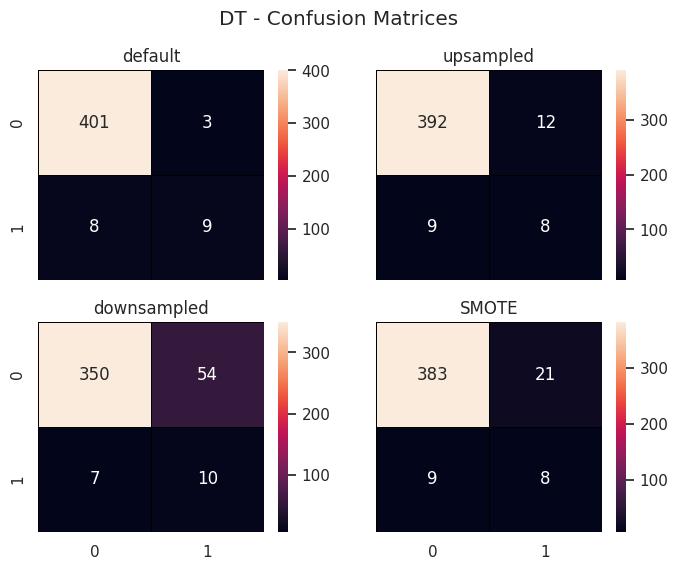

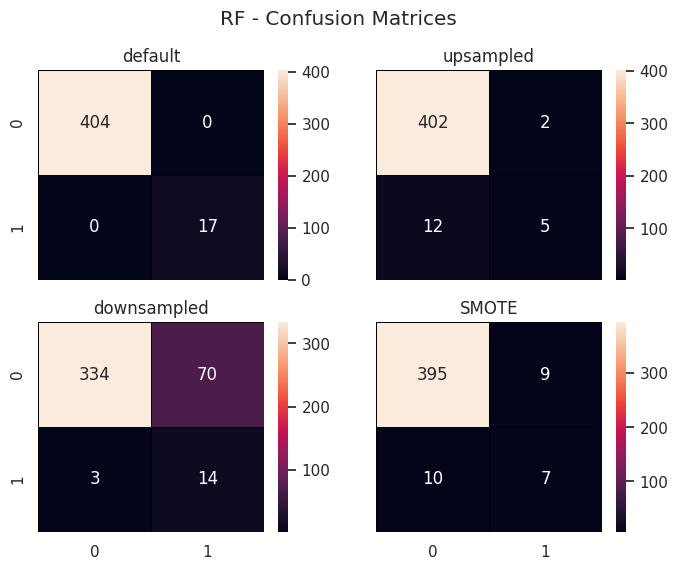

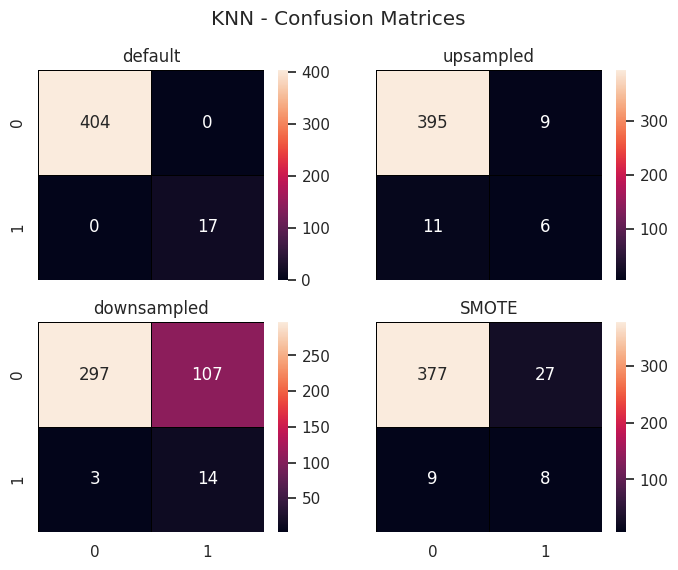

In [ ]:
plot_confusion_matrices(best_f1_ada, 'ADA')
plot_confusion_matrices(best_f1_grb, 'GRB')
plot_confusion_matrices(best_f1_dt, 'DT')
plot_confusion_matrices(best_f1_rf, 'RF')
plot_confusion_matrices(best_f1_knn, 'KNN')

# 6. Προβλέψεις στο άγνωστο σύνολο δεδομένων

#### Επιλογή χαρακτηριστικών

In [ ]:
X = df_un_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]

### 6.1 ADA Boost

In [ ]:
best_overall_ada = max(best_f1_ada.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_ada['params']
# params = results['ADA']['SMOTE'][0]['params']
# params = results['ADA']['default'][0]['params']
params

In [ ]:
model = AdaBoostClassifier(**params)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'ADA'] = pd.DataFrame(un_preds)
ada_n_predicted_oscars = len(df_un_orig[df_un_orig['ADA'] == 1])
ada_n_predicted_oscars

20

### 6.2 Gradient Boost

In [ ]:
best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_grb['params']
# params = results['GRB']['SMOTE'][0]['params']
# params = results['GRB']['default'][0]['params']
params

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 10,
 'subsample': 1.0}

In [ ]:
# best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])

model = GradientBoostingClassifier(**params)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'GRB'] = pd.DataFrame(un_preds)
grb_n_predicted_oscars= len(df_un_orig[df_un_orig['GRB'] == 1])
grb_n_predicted_oscars

0

### 6.3 Decision Tree

In [ ]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_dt['params']
# params = results['DT']['SMOTE'][0]['params']
# params = results['DT']['default'][0]['params']
params

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'splitter': 'random'}

In [ ]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])

model = DecisionTreeClassifier(**params)

model.fit(best_overall_dt['X_train'], best_overall_dt['y_train'])
un_preds = model.predict(X)

df_un_orig[f'DT'] = pd.DataFrame(un_preds)
dt_n_predicted_oscars = len(df_un_orig[df_un_orig['DT'] == 1])
dt_n_predicted_oscars

15

### 6.4 Random Forest

In [ ]:
best_overall_rf = max(best_f1_rf.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_rf['params']
# params = results['RF']['SMOTE'][0]['params']
# params = results['RF']['default'][0]['params']
params

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [ ]:
model = RandomForestClassifier(**params)

model.fit(best_overall_rf['X_train'], best_overall_rf['y_train'])
un_preds = model.predict(X)

df_un_orig[f'RF'] = pd.DataFrame(un_preds)
rf_n_predicted_oscars = len(df_un_orig[df_un_orig['RF'] == 1])
rf_n_predicted_oscars

22

### 6.5 K-Nearest Neighbors

In [ ]:
best_overall_knn = max(best_f1_knn.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_knn['params']
# params = results['KNN']['SMOTE'][0]['params']
# params = results['KNN']['default'][0]['params']
params

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'weights': 'distance'}

In [ ]:
model = KNeighborsClassifier(**params)
model.fit(best_overall_knn['X_train'], best_overall_knn['y_train'])

un_preds = model.predict(X)
preds_df = pd.DataFrame(un_preds)
df_un_orig[f'KNN'] = preds_df

knn_n_predicted_oscars = len(df_un_orig[df_un_orig['KNN'] == 1])
knn_n_predicted_oscars

22

## Εκτύπωση προβλέψεων στο άγνωστο σύνολο δεδομένων

In [ ]:
#['ADA', 'GRB', 'DT','RF', 'KNN']
n_oscar_preds = pd.DataFrame([[ada_n_predicted_oscars, grb_n_predicted_oscars, dt_n_predicted_oscars, rf_n_predicted_oscars, knn_n_predicted_oscars]], columns=['ADA', 'GRB', 'DT','RF', 'KNN'])

Number of predictions per model

In [ ]:
n_oscar_preds

ADA  GRB  DT  RF  KNN
0   20    0  15  22   22

Detailed predictions view

In [ ]:
# df_un_orig[(df_un_orig['ADA'] == 1) | (df_un_orig['GRB'] == 1) | (df_un_orig['DT'] == 1) | (df_un_orig['RF'] == 1) | (df_un_orig['KNN'] == 1)][['ID','ADA', 'GRB', 'DT','RF', 'KNN']]

Select final oscar prediction criteria

In [ ]:
# Majority vote
# DECISION_THRESHOLD = 4
# predictions = df_un_orig[['ID', 'ADA', 'GRB', 'DT','RF', 'KNN']]
# predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)

In [ ]:
# Use only best F1 score models
predictions = df_un_orig[['ID']]
predictions['OSCAR'] = df_un_orig[['ADA', 'RF', 'KNN']].apply(lambda row: 1 if (row['ADA'] + row['RF'] + row['KNN'] == 3) else 0, axis=1)

/tmp/ipykernel_9488/448815872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['RF'] + row['KNN'] == 3) else 0, axis=1)


Overall oscar prediction number

In [ ]:
len(predictions[predictions['OSCAR'] == 1])

20

In [ ]:
print(f"Unkn dataset predicted oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / len(predictions) * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset predicted oscar ratio: 3.54% | Testing dataset oscar prediction ratio: 3.99%


In [ ]:
# Save file
# predictions.to_csv('./predictions_BEST.csv', index=False)